# Harnessing Meteorological Indicators for Rain Prediction
**Aim**: 
1. Analysing weather data of Australia stored in weatherAUS.csv, downloaded from [Kaggle](https://www.kaggle.com/datasets/trisha2094/weatheraus).
2. Design models to predict whether or not it will rain today and tomorrow using weather variables available in the data.
4. Deploy the best model.

In [1]:
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle
import json

## Importing the DataSet

In [2]:
df = pd.read_csv('../data/weatherAUS.csv')

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Data Analysis

### Data Summary

In [4]:
df.shape

(145460, 23)

The DataSet contains 145460 training examples(rows) and has 23 variables(columns).

Looking at the columns provided in the dataset with their data types.

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

According to the author of this dataset, each column defines a particular metric that is useful for predicting Rainfall and the data is taken directly from Austrailian Bureau of Meteorology. Below is a table of what each column represents with its respective unit.

| **Column Name** | **Definition** | **Units** |
| --------------- | -------------- | --------- |
| `Date` | Date of the Observation taken| N/A |
| `Location` | Location of the Weather Station | N/A |
| `MinTemp` | Minimum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `MaxTemp` | Maximum temperature in the 24 hours to 9am. Sometimes only known to the nearest whole degree | Degrees Celsius |
| `Rainfall` | Precipitation (rainfall) in the 24 hours to 9am. Sometimes only known to the nearest whole millimeter | Millimeters |
| `Evaporation` | "Class A" pan evaporation in the 24 hours to 9am | Millimeters |
| `Sunshine` | Bright sunshine in the 24 hours to midnight | Hours |
| `WindGustDir` | Direction of the strongest wind gust in the 24 hours to midnight | 16 compass points |
| `WindGustSpeed` | Speed of the strongest wind gust in the 24 hours to midnight | Kilometers per hour |
| `WindDir9am` | Direction of the wind at 9am | 16 compass points |
| `WindDir3pm` | Direction of the wind at 3pm | 16 compass points |
| `WindSpeed9am` | Speed of the wind at 9am | Kilometers per hour |
| `WindSpeed3pm` | Speed of the wind at 3pm | Kilometers per hour |
| `Humidity9am` | Relative humidity at 9am | Percent |
| `Humidity3pm` | Relative humidity at 3pm | Percent |
| `Pressure9am` | Atmospheric pressure reduced to mean sea level at 9am | Hectopascals |
| `Pressure3pm` | Atmospheric pressure reduced to mean sea level at 3pm | Hectopascals |
| `Cloud9am` | Fraction of sky obscured by cloud at 9am | Eighths(oktas) |
| `Cloud3pm` | Fraction of sky obscured by cloud at 3pm | Eighths(oktas) |
| `Temp9am` | Temparature at 9am | Degrees Celsius |
| `Temp3pm` | Temparature at 3am | Degrees Celsius |
| `RainToday` | Did the current day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |
| `RainTomorrow` | Did the next day receive precipitation exceeding 1mm in the 24 hours to 9am | Binary (0 = No, 1 = Yes) |

By looking at the above tables, we can infer:
 - Date column needs to be converted into datetime format for Data Analysis.
 - Also, change name of Rainfall column to Precipitation for clarity.
 - Rest all columns seems fine to me.

Many columns have missing values that needs to be handled.

### Statistical Analysis

**Numerical Variables**

In [6]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,143975.000000,144199.000000,142199.000000,82670.000000,75625.000000,135197.000000,143693.000000,142398.000000,142806.000000,140953.000000,130395.00000,130432.000000,89572.000000,86102.000000,143693.000000,141851.00000
mean,12.194034,23.221348,2.360918,5.468232,7.611178,40.035230,14.043426,18.662657,68.880831,51.539116,1017.64994,1015.255889,4.447461,4.509930,16.990631,21.68339
std,6.398495,7.119049,8.478060,4.193704,3.785483,13.607062,8.915375,8.809800,19.029164,20.795902,7.10653,7.037414,2.887159,2.720357,6.488753,6.93665
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.50000,977.100000,0.000000,0.000000,-7.200000,-5.40000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.90000,1010.400000,1.000000,2.000000,12.300000,16.60000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.60000,1015.200000,5.000000,5.000000,16.700000,21.10000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.40000,1020.000000,7.000000,7.000000,21.600000,26.40000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.00000,1039.600000,9.000000,9.000000,40.200000,46.70000


- Multiple columns have clear outliers. The difference between the 75th percentile and max is huge.
    - Rainfall(Precipitation)
    - Evaporation
    - WindGustSpeed
    - WindSpeed9am
    - WindSpeed3pm
- Cloud9am and Cloud3pm columns have out of bounds value. They can vary from 0-8 but has value 9 as their max.
- Rest all columns seem statistically/quantitatively correct.

**Non-Numerical Variables**

In [7]:
df.describe(include = ['O'])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,145460,145460,135134,134894,141232,142199,142193
unique,3436,49,16,16,16,2,2
top,2013-11-12,Canberra,W,N,SE,No,No
freq,49,3436,9915,11758,10838,110319,110316


## Data Handling

### **Date**
This is one of the most important feature in this whole data set as most of weather trends are periodical.  
As stated above it needs to be converted into datetime format.

In [8]:
#Convert into datetime format
df['Date'] = pd.to_datetime(df['Date'])

#Make a DataSeries for Month of each training example
Month = df['Date'].dt.month

#Insert Month as a column into the DataFrame
df.insert(1, 'Month', Month)

In [9]:
df.head()

,Date,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,12,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,12,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,12,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,12,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,12,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [10]:
type(df['Date'][0])

pandas._libs.tslibs.timestamps.Timestamp

### **Missing Values**

Visualising how much values each column is missing in terms of our data.

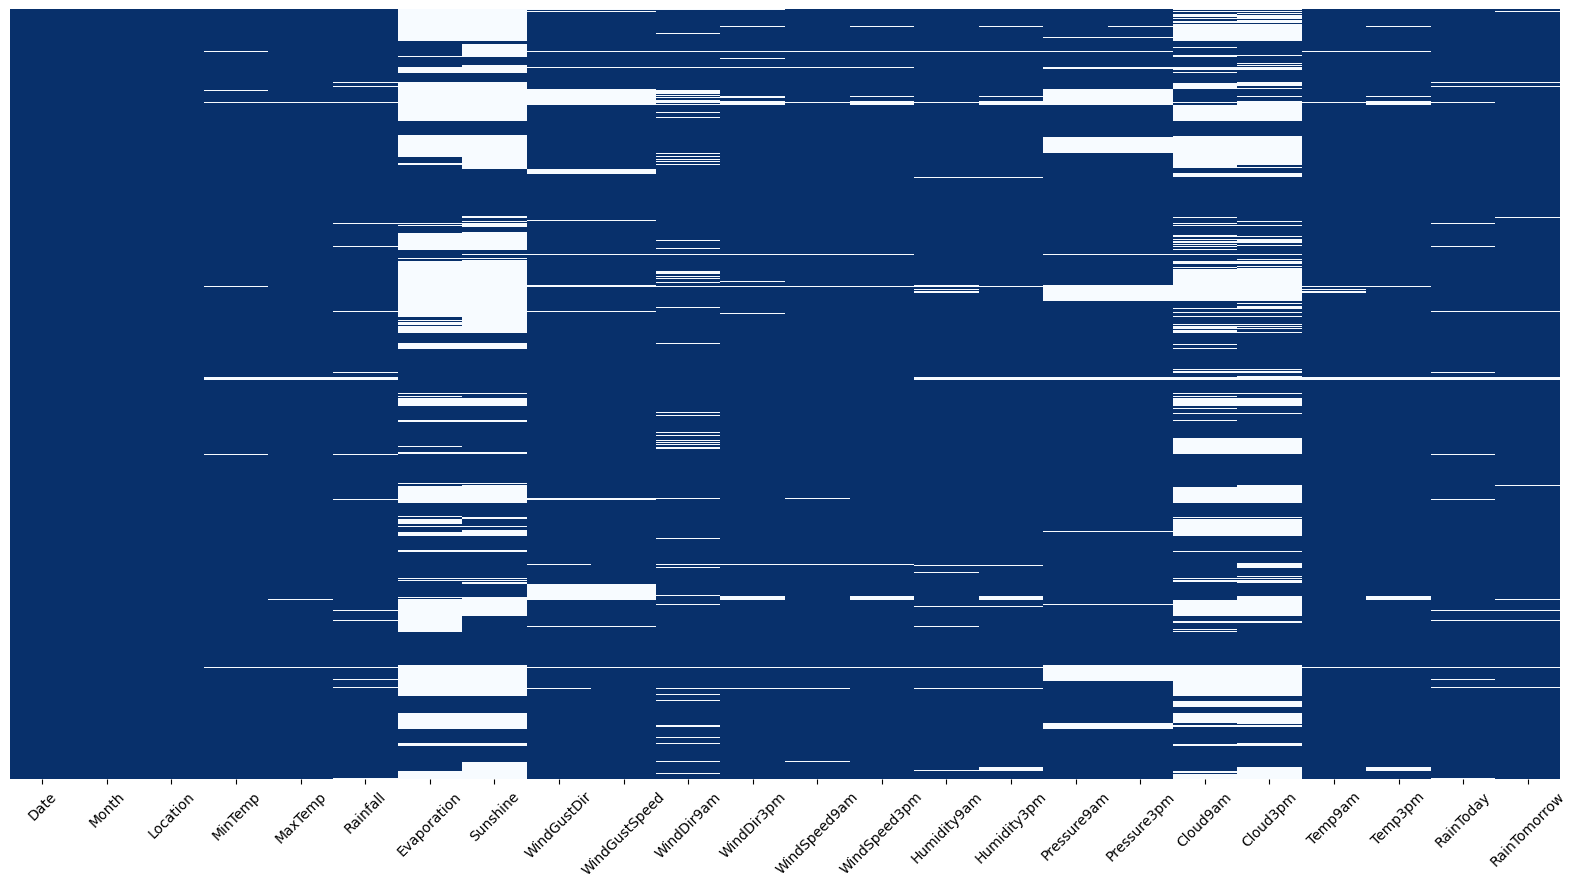

In [11]:
fig = plt.figure()
fig.set_size_inches(20, 10, forward = True)
sns.heatmap(df.isnull(), yticklabels=False, cbar = False, cmap = 'Blues_r')
plt.xticks(rotation=45)
plt.show()

In [12]:
Total = df.isnull().sum()
Percentage = df.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,1485,1.020899
MaxTemp,1261,0.866905
Rainfall,3261,2.241853
Evaporation,62790,43.166506
Sunshine,69835,48.009762
WindGustDir,10326,7.098859
WindGustSpeed,10263,7.055548


- Deleting rows having missing values in dependent variables.
- Deleting from independent variables columns having <= 3.5% missing values(value is chosen randomly).
- Imputing in rest: 
    - Numerical Columns - mean/median
    - Non-Numerical Columns - mode

#### Deletion

**Dependent Variables**

In [13]:
df = df[~df['RainToday'].isnull()]
df = df[~df['RainTomorrow'].isnull()]

In [14]:
Total = df.isnull().sum()
Percentage = df.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,468,0.332417
MaxTemp,307,0.218060
Rainfall,0,0.000000
Evaporation,59694,42.400222
Sunshine,66805,47.451114
WindGustDir,9163,6.508413
WindGustSpeed,9105,6.467216


Deleted rows where dependent variables had null values.

**Independent Variables**

In [15]:
#Separating needed columns
A = Percentage.index[(Percentage<3.5) & (Percentage!=0.0)]

#Making a temporary dataset of selected columns
dfa = df[A].copy()

#Deleting rows from the temporary dataset
dfa.dropna(axis = 0, inplace=True)

#Using indices that are common in main dataset and temporary dataset to filter missing value from main dataset
x = dfa.index.values
df2 = df.loc[x,:]

In [16]:
#Verify
Total = df2.isnull().sum()
Percentage = df2.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,56101,41.682889
Sunshine,61854,45.957352
WindGustDir,6014,4.468385
WindGustSpeed,6001,4.458727


Removed columns where less than 3.5% of the values were missing.

#### Imputation

- During statistical analysis, it was seen that some columns had outliers.  
- **Imputation Method** = **Median**, because median is more robust to outliers.

**1. Evaporation** 

***Visualising*** the column to see its behaviour for 3 different locations.

In [17]:
#Select a particular location and make a temporary dataset
Loc = df2['Location'].unique()[15]
Vdf = df2[df2['Location'] == Loc]

print(f'Total number of records at {Loc} = {Vdf.shape[0]}')
print(f"Number of missing records in Evaporation column at {Loc} =  {Vdf['Evaporation'].isnull().sum()}")

Total number of records at Canberra = 3104
Number of missing records in Evaporation column at Canberra =  1564


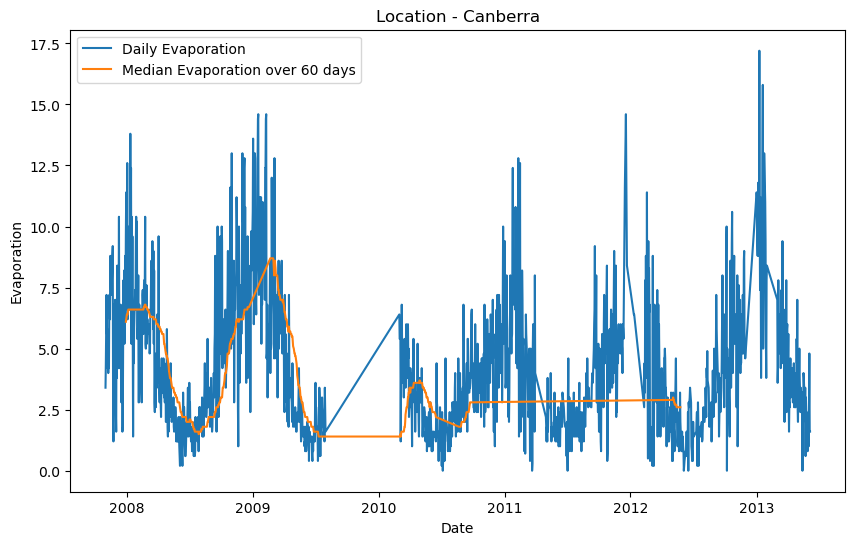

In [18]:
plt.figure(figsize = (10,6))

#Plotting a lineplot and see how the column varies
sns.lineplot(x = 'Date', y = 'Evaporation', data = Vdf, label = 'Daily Evaporation')

#Plotting a line plot for Moving Median of 60 days
M = Vdf.Evaporation.rolling(60).median()
sns.lineplot(x = 'Date', y = M, data = Vdf, label = 'Median Evaporation over 60 days')

plt.title("Location - "+Loc)

plt.show()

- The data is not always continuos : 
   - Between min 2009 and early 2010 because of removing null values
   - Around early 2012 because of values not being present, in the column.
   - Completely missing values after mid 2013.

In [19]:
#Select a particular location and make a temporary dataset
Loc = df2['Location'].unique()[37]
Vdf = df2[df2['Location'] == Loc]

print(f'Total number of records at {Loc} = {Vdf.shape[0]}')
print(f"Number of missing records in Evaporation column at {Loc} =  {Vdf['Evaporation'].isnull().sum()}")

Total number of records at Witchcliffe = 2660
Number of missing records in Evaporation column at Witchcliffe =  2660


All records are missing in evaporation column at Wiychcliffe.

In [20]:
#Select a particular location and make a temporary dataset
Loc = df2['Location'].unique()[39]
Vdf = df2[df2['Location'] == Loc]

print(f'Total number of records at {Loc} = {Vdf.shape[0]}')
print(f"Number of missing records in Evaporation column at {Loc} =  {Vdf['Evaporation'].isnull().sum()}")

Total number of records at PerthAirport = 3006
Number of missing records in Evaporation column at PerthAirport =  1


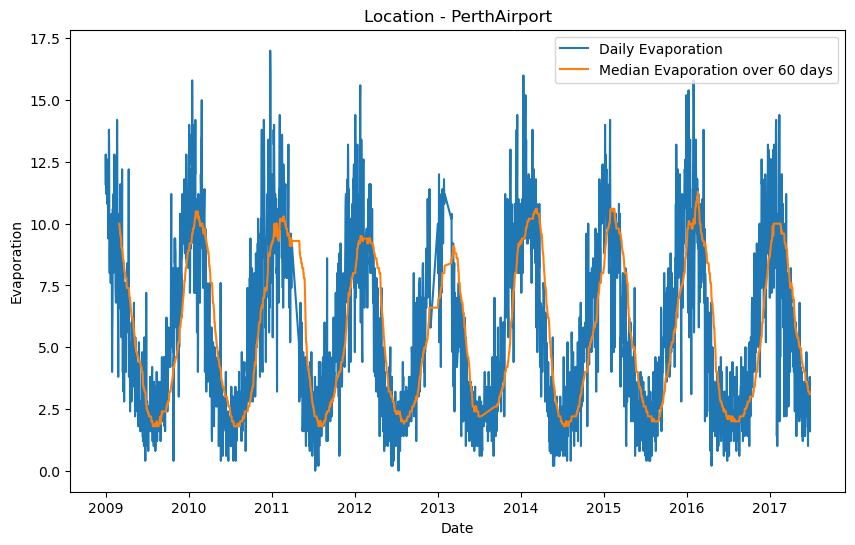

In [21]:
plt.figure(figsize = (10,6))

#Plotting a lineplot for each value and see how the column varies
sns.lineplot(x = 'Date', y = 'Evaporation', data = Vdf, label = 'Daily Evaporation')

#Plotting a line plot for Moving Median of 60 days
M = Vdf.Evaporation.rolling(60).median()
sns.lineplot(x = 'Date', y = M, data = Vdf, label = 'Median Evaporation over 60 days')

plt.title("Location - "+Loc)

plt.show()

- Only 1 value is missing for this location.  
- The values are periodic over the years' time.

***Imputing*** median grouped according to the month.

In [22]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df2[df2['Evaporation'].isnull()].copy()
dfx = df2[~df2['Evaporation'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['Evaporation'].median()

#Making a function to impute null values according to the month it belongs to.
def impute_E(x):
    if(x in a):
        return a[x]

#Applying the function on dfy
dfy['Evaporation'] = dfy['Month'].apply(impute_E)

#Joining dfy and dfx and sorting the indices
df3 = pd.concat((dfx,dfy), axis = 0)
df3.sort_index(inplace = True)

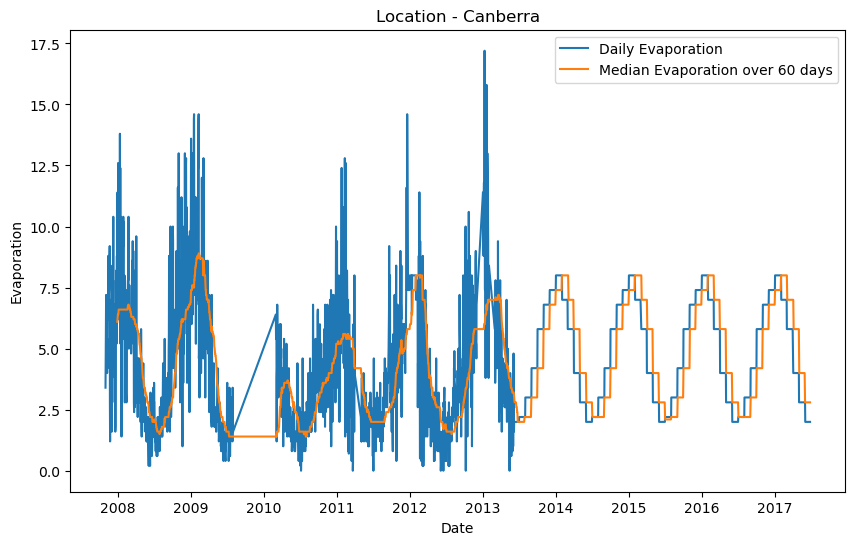

In [23]:
# Visualise after imputation

Loc = df3['Location'].unique()[15]
Vdf = df3[df3['Location'] == Loc]

plt.figure(figsize = (10,6))

sns.lineplot(x = 'Date', y = 'Evaporation', data = Vdf, label = 'Daily Evaporation')

M = Vdf.Evaporation.rolling(60).median()
sns.lineplot(x = 'Date', y = M, data = Vdf, label = 'Median Evaporation over 60 days')

plt.title("Location - "+Loc)

plt.show()

- Since values between mind 2009 and early 2010 were deleted beforehand, graph is same there.
- At other places values are imputed and graph looks complete.

In [24]:
#Verify
Total = df3.isnull().sum()
Percentage = df3.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,0,0.000000
Sunshine,61854,45.957352
WindGustDir,6014,4.468385
WindGustSpeed,6001,4.458727


**2. Sunshine**

***Visualising*** the column to see its behaviour

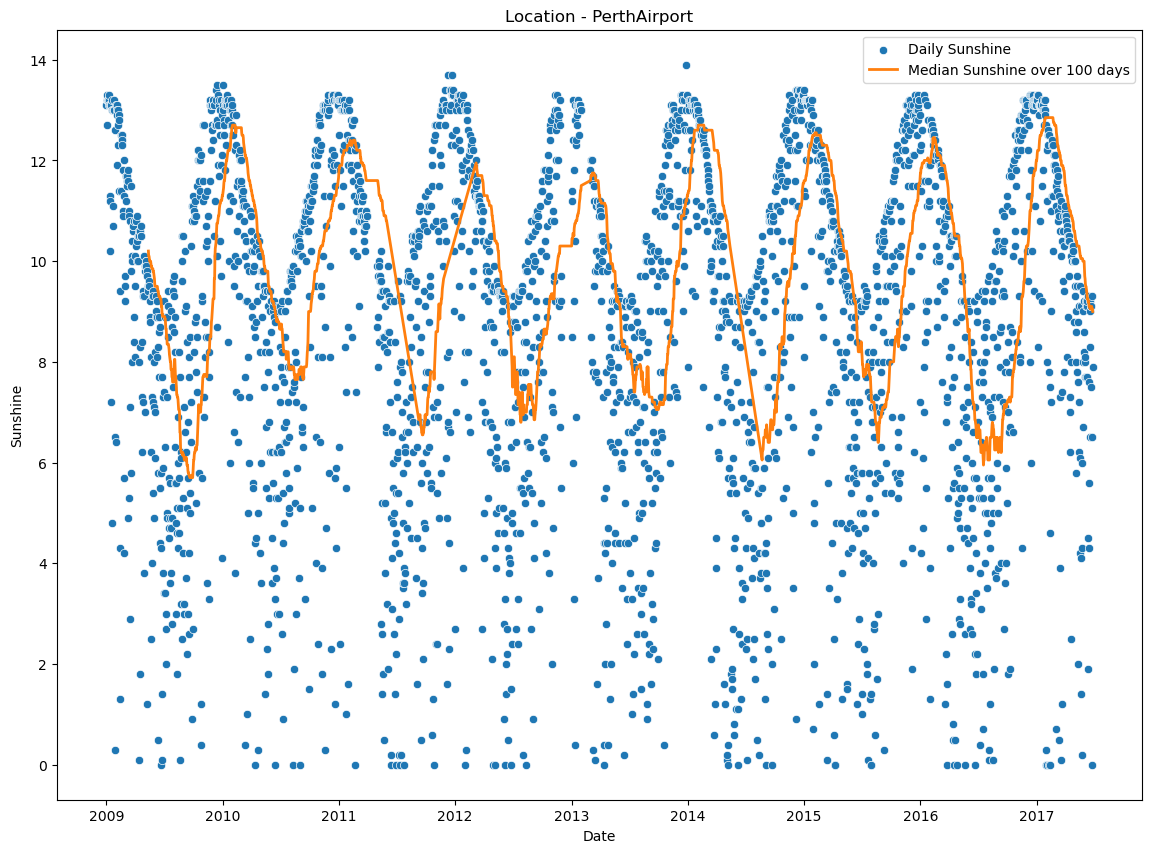

In [25]:
#Select a particular location and make a temporary dataset
Loc = df3['Location'].unique()[39]
Vdf = df3[df3['Location'] == Loc]

plt.figure(figsize = (14,10))

#Plotting a scatterplot and see how the column varies
sns.scatterplot(x = 'Date', y = 'Sunshine', data = Vdf, label = 'Daily Sunshine')

#Plotting a line plot for Moving Median of 100 days
M = Vdf.Sunshine.rolling(100).median()
sns.lineplot(x = 'Date', y = M, data = Vdf, label = 'Median Sunshine over 100 days', color = 'tab:orange', linewidth = 2)

plt.title("Location - "+Loc)

plt.show()

- Sunshine on a daily level follows very random trend.
- It's median value follows a monthly trend and is periodic over a year.

***Imputing*** median grouped according to the month.

In [26]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df3[df3['Sunshine'].isnull()].copy()
dfx = df3[~df3['Sunshine'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['Sunshine'].median()

#Making a function to impute null values according to the month it belongs to.
def impute_S(x):
    if x in a:
        return a[x]

#Applying the function on dfy
dfy['Sunshine'] = dfy['Month'].apply(impute_S)

#Joining dfy and dfx and sorting the indices
df4 = pd.concat((dfx,dfy), axis = 0)
df4.sort_index(inplace = True)

In [27]:
#Verify
Total = df4.isnull().sum()
Percentage = df4.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,0,0.000000
Sunshine,0,0.000000
WindGustDir,6014,4.468385
WindGustSpeed,6001,4.458727


**3. WindGustSpeed**

***Visualising*** the column to see its behaviour

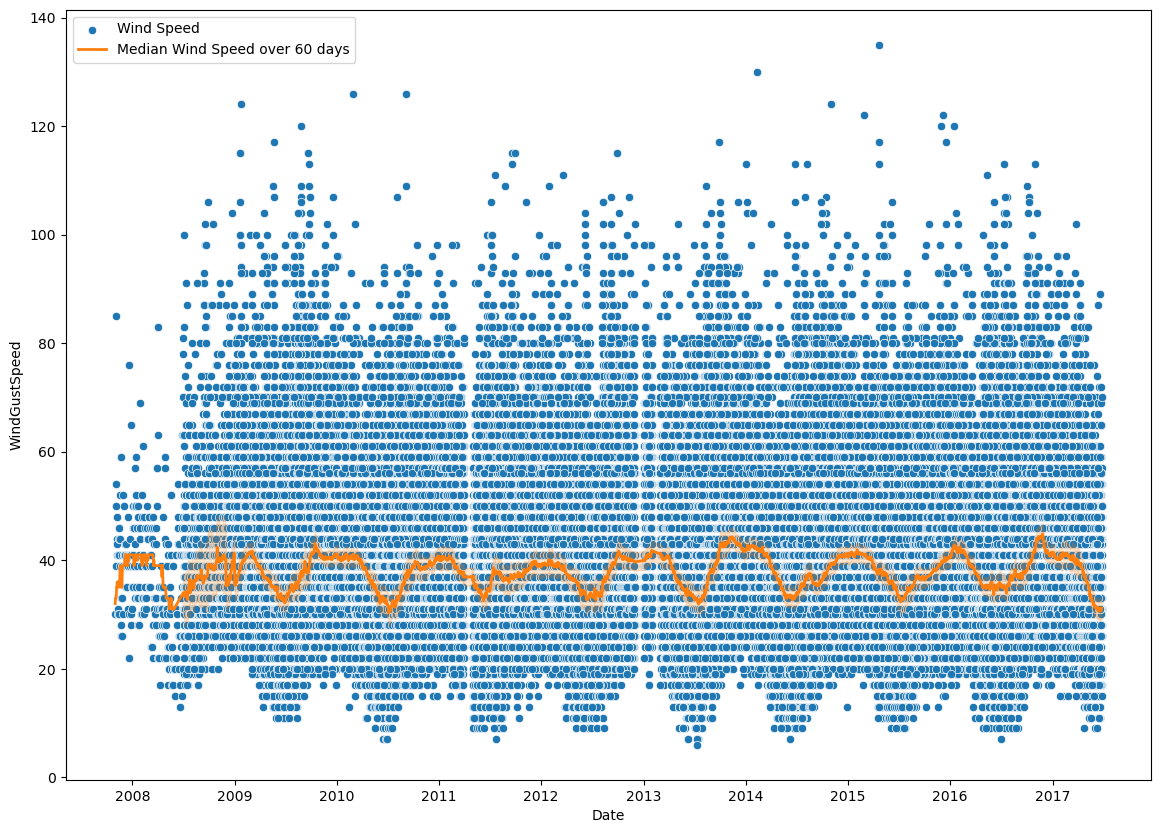

In [28]:
#Not using Location since wind speeds are very random individually.
plt.figure(figsize = (14,10))

#Plotting a scatterplot and see how the column varies
sns.scatterplot(x = 'Date', y = 'WindGustSpeed', data = df4, label = 'Wind Speed')

#Plotting a line plot for Moving Median of 100 days
M = df4.WindGustSpeed.rolling(60).median()
sns.lineplot(x = 'Date', y = M, data = df4, label = 'Median Wind Speed over 60 days', color = 'tab:orange', linewidth = 2)

plt.show()

- The median speed of wind is highest in May-July time for that year.
- Around December-January, it is the slowest.  
- Individually they are very random.

Small percentage of values are missing for this column as opposed to the previous two. Hence, it is worth checking if location can also be incorporated for imputation.

In [29]:
pd.set_option('display.max_rows', 588)
print(df4.groupby(['Location','Month'])['WindGustSpeed'].median())

Location          Month
Adelaide          1        37.0
                  2        37.0
                  3        33.0
                  4        30.0
                  5        30.0
                  6        30.0
                  7        35.0
                  8        37.0
                  9        37.0
                  10       37.0
                  11       39.0
                  12       37.0
Albany            1         NaN
                  2         NaN
                  3         NaN
                  4         NaN
                  5         NaN
                  6         NaN
                  7         NaN
                  8         NaN
                  9         NaN
                  10        NaN
                  11        NaN
                  12        NaN
Albury            1        37.0
                  2        33.0
                  3        31.0
                  4        26.0
                  5        24.0
                  6        20.0
                

For some location it is NaN, hence location cannot be used.

***Imputing*** median grouped according to the month.

In [30]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df4[df4['WindGustSpeed'].isnull()].copy()
dfx = df4[~df4['WindGustSpeed'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['WindGustSpeed'].median()

#Making a function to impute null values according to the month it belongs to.
def impute_W(x):
    if x in a:
        return a[x]

#Applying the function on dfy
dfy['WindGustSpeed'] = dfy['Month'].apply(impute_W)

#Joining dfy and dfx and sorting the indices
df5 = pd.concat((dfx,dfy), axis = 0)
df5.sort_index(inplace = True)

In [31]:
#Verify
Total = df5.isnull().sum()
Percentage = df5.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,0,0.000000
Sunshine,0,0.000000
WindGustDir,6014,4.468385
WindGustSpeed,0,0.000000


**4. Pressure9am**

***Visualising*** the column to see its behaviour

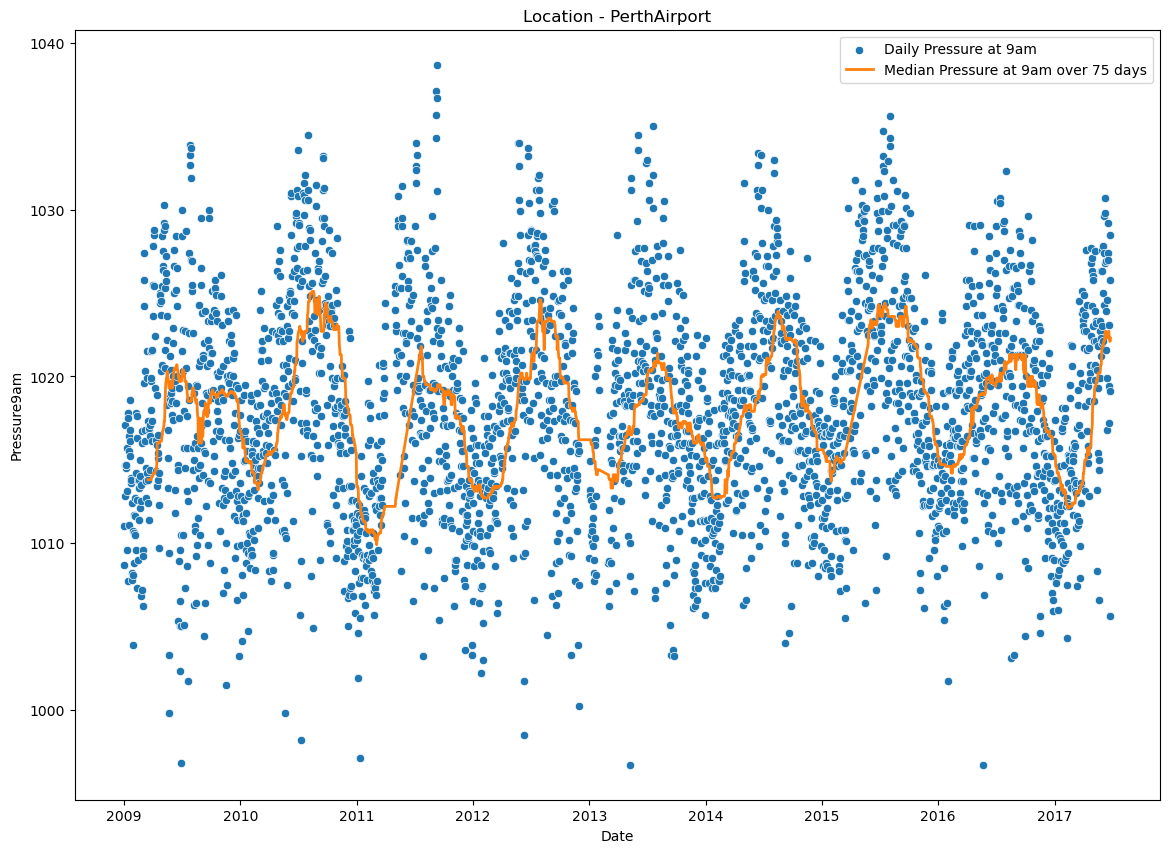

In [32]:
#Select a particular location and make a temporary dataset
Loc = df5['Location'].unique()[39]
Vdf = df5[df5['Location'] == Loc]

plt.figure(figsize = (14,10))

#Plotting a scatterplot and see how the column varies
sns.scatterplot(x = 'Date', y = 'Pressure9am', data = Vdf, label = 'Daily Pressure at 9am')

#Plotting a line plot for Moving Median of 100 days
M = Vdf.Pressure9am.rolling(75).median()
sns.lineplot(x = 'Date', y = M, data = Vdf, label = 'Median Pressure at 9am over 75 days', color = 'tab:orange', linewidth = 2)

plt.title("Location - "+Loc)

plt.show()

- Daily Pressure also is very random.
- It's median value follows a monthly trend and is periodic over a year.

In [33]:
# Checking for Location
pd.set_option('display.max_rows', 600)
print(df5.groupby(['Location','Month'])['Pressure9am'].median())

Location          Month
Adelaide          1        1013.80
                  2        1016.05
                  3        1017.85
                  4        1021.80
                  5        1021.80
                  6        1024.20
                  7        1022.70
                  8        1021.25
                  9        1020.00
                  10       1019.85
                  11       1016.50
                  12       1013.55
Albany            1        1015.65
                  2        1016.90
                  3        1019.50
                  4        1019.55
                  5        1020.90
                  6        1021.80
                  7        1020.95
                  8        1018.65
                  9        1017.80
                  10       1019.35
                  11       1017.30
                  12       1015.75
Albury            1        1012.60
                  2        1014.70
                  3        1018.30
                  4        1021

For some location it is NaN, hence location cannot be used.

***Imputing*** median grouped according to the month.

In [34]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df5[df5['Pressure9am'].isnull()].copy()
dfx = df5[~df5['Pressure9am'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['Pressure9am'].median()

#Making a function to impute null values according to the month it belongs to.
def impute_P(x):
    if x in a:
        return a[x]

#Applying the function on dfy
dfy['Pressure9am'] = dfy['Month'].apply(impute_P)

#Joining dfy and dfx and sorting the indices
df6 = pd.concat((dfx,dfy), axis = 0)
df6.sort_index(inplace = True)

In [35]:
#Verify
Total = df6.isnull().sum()
Percentage = df6.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,0,0.000000
Sunshine,0,0.000000
WindGustDir,6014,4.468385
WindGustSpeed,0,0.000000


**5. Pressure3pm**

***Visualising*** the column to see its behaviour

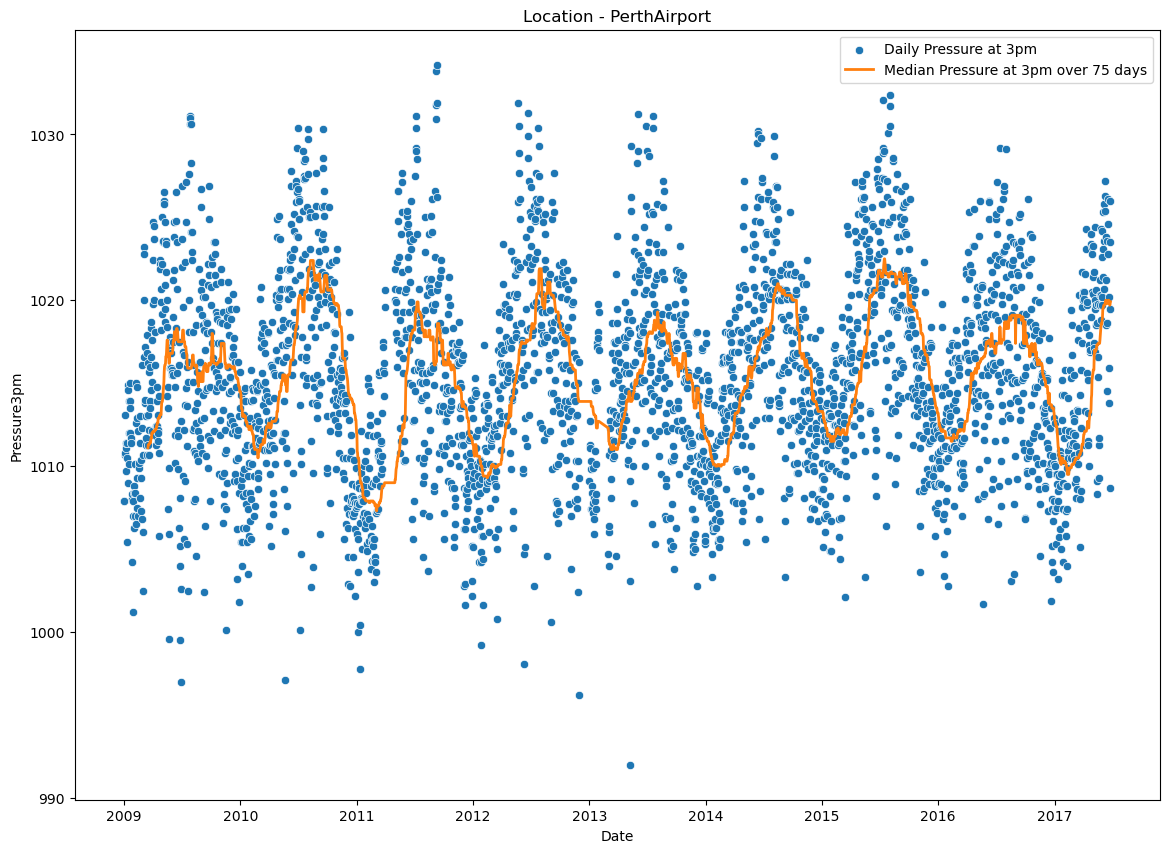

In [36]:
#Select a particular location and make a temporary dataset
Loc = df6['Location'].unique()[39]
Vdf = df6[df6['Location'] == Loc]

plt.figure(figsize = (14,10))

#Plotting a scatterplot and see how the column varies
sns.scatterplot(x = 'Date', y = 'Pressure3pm', data = Vdf, label = 'Daily Pressure at 3pm')

#Plotting a line plot for Moving Median of 100 days
M = Vdf.Pressure3pm.rolling(75).median()
sns.lineplot(x = 'Date', y = M, data = Vdf, label = 'Median Pressure at 3pm over 75 days', color = 'tab:orange', linewidth = 2)

plt.title("Location - "+Loc)

plt.show()

The behaviour is same as Pressure9am.

In [37]:
#Checking for Location
pd.set_option('display.max_rows', 600)
print(df6.groupby(['Location','Month'])['Pressure3pm'].median())

Location          Month
Adelaide          1        1012.05
                  2        1014.45
                  3        1016.40
                  4        1019.50
                  5        1019.50
                  6        1021.75
                  7        1020.90
                  8        1019.15
                  9        1017.60
                  10       1018.05
                  11       1014.65
                  12       1012.05
Albany            1        1014.50
                  2        1015.80
                  3        1017.10
                  4        1017.40
                  5        1019.50
                  6        1019.80
                  7        1019.15
                  8        1016.95
                  9        1015.90
                  10       1017.95
                  11       1015.10
                  12       1014.65
Albury            1        1009.80
                  2        1012.20
                  3        1015.50
                  4        1018

For some location it is NaN, hence location cannot be used.

***Imputing*** median grouped according to the month.

In [38]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df6[df6['Pressure3pm'].isnull()].copy()
dfx = df6[~df6['Pressure3pm'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['Pressure3pm'].median()

#Making a function to impute null values according to the month it belongs to.
def impute_P(x):
    if x in a:
        return a[x]

#Applying the function on dfy
dfy['Pressure3pm'] = dfy['Month'].apply(impute_P)

#Joining dfy and dfx and sorting the indices
df7 = pd.concat((dfx,dfy), axis = 0)
df7.sort_index(inplace = True)

In [39]:
#Verify
Total = df7.isnull().sum()
Percentage = df7.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,0,0.000000
Sunshine,0,0.000000
WindGustDir,6014,4.468385
WindGustSpeed,0,0.000000


**6. Cloud9am and Cloud3pm**

In the data description, it is given that the cloud columns are being measured in 'oktas', which is the measure by which we express the extent of cloud cover. It's value is equal to the 1/8 of the sky. It ranges from 1-8 and is dicrete so, here instead of visualising, we'll see the columns' behavior quantitatively.

***Quantitative Analysis*** to see its behavior.

In [40]:
df7.groupby('Month')[['Cloud9am', 'Cloud3pm']].median()

,Cloud9am,Cloud3pm
Month,,
1,5.0,4.0
2,5.0,5.0
3,5.0,5.0
4,5.0,5.0
5,5.0,5.0
6,6.0,6.0
7,5.0,6.0
8,4.0,5.0
9,4.0,5.0


In [41]:
df7[['Cloud9am', 'Cloud3pm']].median()

Cloud9am    5.0
Cloud3pm    5.0
dtype: float64

The behavior doesn't seem much fluctuating. So, now we'll just impute the median without grouping.  

***Imputation*** with the SimpleImputer Class of Sklearn.

In [42]:
SI = SimpleImputer(missing_values = np.nan, strategy = 'median')

#Applying it in the dataset
df7.loc[:,['Cloud9am']] = SI.fit_transform(df7.loc[:,['Cloud9am']])
df7.loc[:,['Cloud3pm']] = SI.fit_transform(df7.loc[:,['Cloud3pm']])

In [43]:
#Verify
Total = df7.isnull().sum()
Percentage = df7.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.000000
Month,0,0.000000
Location,0,0.000000
MinTemp,0,0.000000
MaxTemp,0,0.000000
Rainfall,0,0.000000
Evaporation,0,0.000000
Sunshine,0,0.000000
WindGustDir,6014,4.468385
WindGustSpeed,0,0.000000


**7. WindGustDir**

**Analysing** counts of unique values in the column with varying month.

In [44]:
a = df7.groupby('Month')['WindGustDir'].value_counts()
a

Month  WindGustDir
1      SE             1127
       SSE            1039
       E               974
       S               954
       ENE             909
       SSW             903
       ESE             763
       SW              760
       NE              755
       WSW             663
       W               600
       NNE             535
       NW              507
       N               473
       WNW             462
       NNW             322
2      SE             1083
       SSE            1028
       E               917
       S               850
       ESE             731
       ENE             686
       SSW             661
       SW              551
       NE              528
       WSW             440
       W               400
       NNE             390
       N               369
       WNW             329
       NW              305
       NNW             295
3      SE             1205
       E              1044
       SSE            1026
       S               893
       ES

In [45]:
dfx.groupby('Month')['WindGustDir'].agg(pd.Series.mode)

Month
1     SE
2     SE
3     SE
4     SE
5      W
6      N
7      N
8      W
9      W
10     W
11    SW
12    SE
Name: WindGustDir, dtype: object

- The most frequent value for WindGustDir is SoutEast during January-March.
- Then around April-May it is West
- Around June-July it is North
- In August-September it agains becomes West
- Then by the end year it is back to SouthEast

***Imputing*** most frequent value(mode) grouped according to the month.

In [46]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df7[df7['WindGustDir'].isnull()].copy()
dfx = df7[~df7['WindGustDir'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['WindGustDir'].agg(pd.Series.mode)

#Making a function to impute null values according to the month it belongs to.
def impute_D(x):
    if(x in a):
        return a[x]

#Applying the function on dfy
dfy['WindGustDir'] = dfy['Month'].apply(impute_D)

#Joining dfy and dfx and sorting the indices
df8 = pd.concat((dfx,dfy), axis = 0)
df8.sort_index(inplace = True)

In [47]:
#Verify
Total = df8.isnull().sum()
Percentage = df8.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.00000
Month,0,0.00000
Location,0,0.00000
MinTemp,0,0.00000
MaxTemp,0,0.00000
Rainfall,0,0.00000
Evaporation,0,0.00000
Sunshine,0,0.00000
WindGustDir,0,0.00000
WindGustSpeed,0,0.00000


**8. WindDir9am**

**Analysing** counts of unique values in the column with varying month.

In [48]:
a = df8.groupby('Month')['WindDir9am'].value_counts()
a

Month  WindDir9am
1      SE            1177
       SSE           1051
       E             1023
       S              955
       ESE            935
       ENE            860
       N              831
       NE             777
       NNE            769
       SSW            736
       SW             606
       NNW            527
       W              494
       WSW            468
       NW             461
       WNW            384
2      SSE            998
       SE             964
       E              892
       S              809
       ESE            791
       ENE            700
       SSW            608
       SW             553
       NE             541
       N              524
       NNE            508
       WSW            393
       NNW            382
       W              370
       NW             311
       WNW            297
3      E             1055
       SE            1045
       SSE           1024
       ESE            922
       S              836
       ENE          

In [49]:
dfx.groupby('Month')['WindDir9am'].agg(pd.Series.mode)

Month
1      SE
2     SSE
3       E
4     SSE
5       N
6       N
7       N
8       N
9       N
10      N
11      N
12    SSE
Name: WindDir9am, dtype: object

The behavior of this column is same like WindGustDir

***Imputing*** most frequent value(mode) grouped according to the month.

In [50]:
#Diving dataset into two temp. dataframe where one stores all eg. with null values(dfy) and other one has rest(dfx).
dfy = df8[df8['WindDir9am'].isnull()].copy()
dfx = df8[~df8['WindDir9am'].isnull()].copy()

#Making a DataSeries to store info about median for every month.
a = dfx.groupby('Month')['WindDir9am'].agg(pd.Series.mode)

#Making a function to impute null values according to the month it belongs to.
def impute_D(x):
    if(x in a):
        return a[x]

#Applying the function on dfy
dfy['WindDir9am'] = dfy['Month'].apply(impute_D)

#Joining dfy and dfx and sorting the indices
df9 = pd.concat((dfx,dfy), axis = 0)
df9.sort_index(inplace = True)

In [51]:
#Verify
Total = df9.isnull().sum()
Percentage = df9.isnull().mean() * 100
Null = pd.DataFrame({'Total' : Total, 'Percentage' : Percentage})
Null

,Total,Percentage
Date,0,0.0
Month,0,0.0
Location,0,0.0
MinTemp,0,0.0
MaxTemp,0,0.0
Rainfall,0,0.0
Evaporation,0,0.0
Sunshine,0,0.0
WindGustDir,0,0.0
WindGustSpeed,0,0.0


All the missing values have been handled. Now we can move towards removing outliers

### Outlier Removal

- 5 columns where huge outliersa are present and might cause problems, as concluded above:
    1. Rainfall(Precipitation)
    1. Evaporation
    1. WindGustSpeed
    1. WindSpeed9am
    1. WindSpeed3pm  

  
- Cloud9am and Cloud3pm columns have wrong value

#### Boxplot to Visualise Outliers

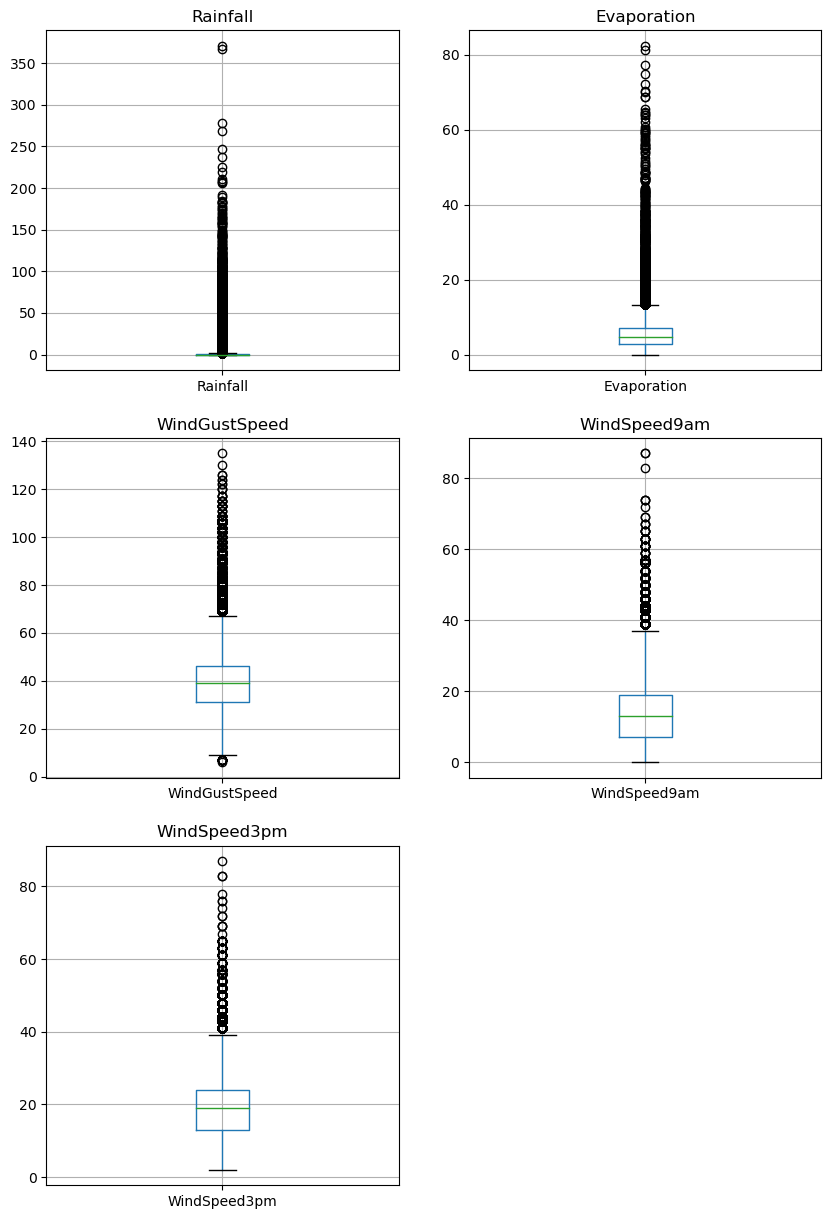

In [52]:
plt.figure(figsize = (10,15))

#Rainfall(Precipitation)
plt.subplot(3,2,1)
a = df9.boxplot(column = 'Rainfall')
a.set_title('Rainfall')

#Evaporation
plt.subplot(3,2,2)
b = df9.boxplot(column = 'Evaporation')
b.set_title('Evaporation')

#WindGustSpeed
plt.subplot(3,2,3)
c = df9.boxplot(column = 'WindGustSpeed')
c.set_title('WindGustSpeed')

#WindSpeed9am
plt.subplot(3,2,4)
d = df9.boxplot(column = 'WindSpeed9am')
d.set_title('WindSpeed9am')

#WindSpeed9am
plt.subplot(3,2,5)
e = df9.boxplot(column = 'WindSpeed3pm')
e.set_title('WindSpeed3pm')

plt.show()

The above boxplots confirm that there are lot of outliers in these variables.

#### Removing Outliers

In [53]:
#Defining a function with returns 3rd standard deviation for a column
def metric(x):
    mu = x.mean()
    sigma = x.std()
    return (mu - (3 * sigma)) , (mu + (3 * sigma))


#Rainfall
S = metric(df9['Rainfall'])
dfa = df9[(df9['Rainfall'] >= S[0]) & (df9['Rainfall'] <= S[1]) ].copy()

#Evaporation
S = metric(df9['Evaporation'])
dfb = dfa[(dfa['Evaporation'] >= S[0]) & (dfa['Evaporation'] <= S[1]) ].copy()

#WindGustSpeed
S = metric(df9['WindGustSpeed'])
dfc = dfb[(dfb['WindGustSpeed'] >= S[0]) & (dfb['WindGustSpeed'] <= S[1]) ].copy()

#WindSpeed9am
S = metric(df9['WindSpeed9am'])
dfd = dfc[(dfc['WindSpeed9am'] >= S[0]) & (dfc['WindSpeed9am'] <= S[1]) ].copy()

#WindSpeed3pm
S = metric(df9['WindSpeed3pm'])
df10 = dfd[(dfd['WindSpeed3pm'] >= S[0]) & (dfd['WindSpeed3pm'] <= S[1]) ].copy()

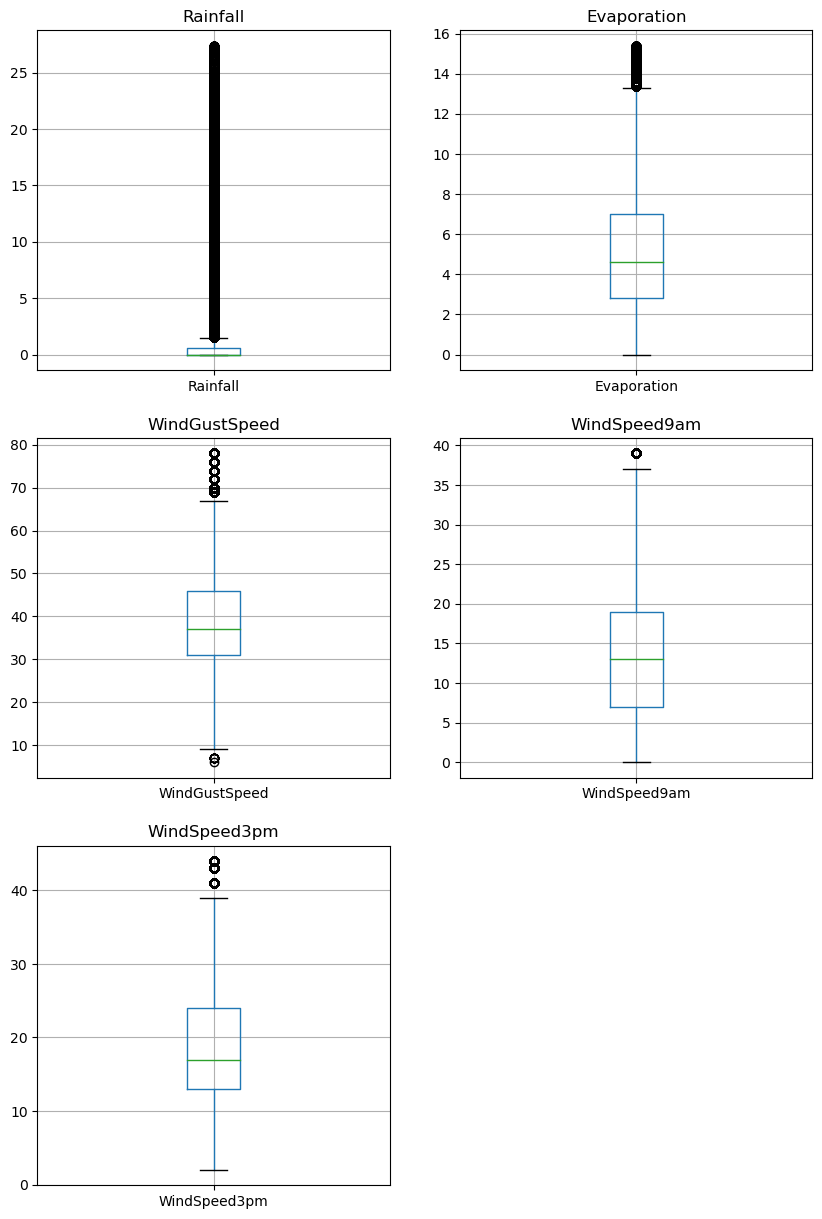

In [54]:
plt.figure(figsize = (10,15))

#Rainfall
plt.subplot(3,2,1)
a = df10.boxplot(column = 'Rainfall')
a.set_title('Rainfall')

#Evaporation
plt.subplot(3,2,2)
b = df10.boxplot(column = 'Evaporation')
b.set_title('Evaporation')

#WindGustSpeed
plt.subplot(3,2,3)
c = df10.boxplot(column = 'WindGustSpeed')
c.set_title('WindGustSpeed')

#WindSpeed9am
plt.subplot(3,2,4)
d = df10.boxplot(column = 'WindSpeed9am')
d.set_title('WindSpeed9am')

#WindSpeed3pm
plt.subplot(3,2,5)
e = df10.boxplot(column = 'WindSpeed3pm')
e.set_title('WindSpeed3pm')

plt.show()

- We can now see that the outliers in `Rainfall(Precipitation)`, `Evaporation`, `WindSpeed9am` and `WindSpeed3pm` columns are capped and the values chosen are inside a convincing range range.
- Even though for Rainfall(Precipiation) 75th percentile and max have a huge difference but these values can be seen for Precipitation on a general basis.

#### Removing wrong value for Cloud columns

Cloud 9am and 3pm having value 9 is not possible.

In [55]:
#Analysing counts of each value
print(df10['Cloud9am'].value_counts())
print(df10['Cloud3pm'].value_counts())

Cloud9am
5.0    53391
7.0    17959
1.0    14384
8.0    12294
0.0     7603
6.0     7183
2.0     5974
3.0     5400
4.0     3963
9.0        2
Name: count, dtype: int64
Cloud3pm
5.0    55959
7.0    16506
1.0    14056
8.0    10835
6.0     8153
2.0     6742
3.0     6434
4.0     4892
0.0     4575
9.0        1
Name: count, dtype: int64


Removing these examples and our data won't have any affect since the number is very small as compared to size of the dataset

In [56]:
df10 = df10[(df10['Cloud3pm'] != 9.0) & (df10['Cloud9am'] != 9.0)]

In [57]:
df10.reset_index(drop = True, inplace = True)

In [58]:
df10.describe()

,Date,Month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,128150,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000,128150.000000
mean,2013-03-21 14:52:53.393679360,6.408670,12.025476,23.191491,1.460968,5.033504,8.122925,38.957089,13.596215,18.367624,68.761522,51.097440,1017.952170,1015.525640,4.623457,4.661233,16.862482,21.700688
min,2007-11-01 00:00:00,1.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,1.000000,0.000000,982.200000,978.200000,0.000000,0.000000,-7.200000,-5.400000
25%,2010-12-31 00:00:00,3.000000,7.500000,18.000000,0.000000,2.800000,6.600000,31.000000,7.000000,13.000000,57.000000,36.000000,1013.500000,1011.100000,3.000000,4.000000,12.200000,16.700000
50%,2013-05-14 00:00:00,6.000000,11.800000,22.600000,0.000000,4.600000,8.700000,37.000000,13.000000,17.000000,70.000000,52.000000,1018.000000,1015.500000,5.000000,5.000000,16.600000,21.200000
75%,2015-05-23 00:00:00,9.000000,16.600000,28.100000,0.600000,7.000000,10.200000,46.000000,19.000000,24.000000,83.000000,65.000000,1022.100000,1019.700000,6.000000,6.000000,21.400000,26.400000
max,2017-06-25 00:00:00,12.000000,33.900000,47.300000,27.400000,15.400000,14.500000,78.000000,39.000000,44.000000,100.000000,100.000000,1041.000000,1039.600000,8.000000,8.000000,40.200000,46.700000
std,NaN,3.413432,6.351588,6.983823,3.838941,2.778504,2.939633,11.913833,8.173947,8.129151,18.779923,20.378599,6.694716,6.643829,2.288323,2.141252,6.438358,6.843292


## Encoding Categorical Variables  

In [59]:
df10.dtypes

Date             datetime64[ns]
Month                     int32
Location                 object
MinTemp                 float64
MaxTemp                 float64
Rainfall                float64
Evaporation             float64
Sunshine                float64
WindGustDir              object
WindGustSpeed           float64
WindDir9am               object
WindDir3pm               object
WindSpeed9am            float64
WindSpeed3pm            float64
Humidity9am             float64
Humidity3pm             float64
Pressure9am             float64
Pressure3pm             float64
Cloud9am                float64
Cloud3pm                float64
Temp9am                 float64
Temp3pm                 float64
RainToday                object
RainTomorrow             object
dtype: object

All the categorical variables are:  
  - Month
  - Location
  - WindGustDir
  - WindDir9am
  - WindDir3pm
  - RainToday
  - RainTomorrow

In [60]:
Cat = ['Month', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
for i in Cat:
    print(i,':\n',df10[i].unique())

Month :
 [12  1  2  3  4  5  6  7  8  9 10 11]
Location :
 ['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
WindGustDir :
 ['W' 'WNW' 'WSW' 'NE' 'N' 'NNE' 'SW' 'ENE' 'SSE' 'S' 'NNW' 'NW' 'SE' 'ESE'
 'E' 'SSW']
WindDir9am :
 ['W' 'NNW' 'SE' 'ENE' 'SW' 'SSE' 'S' 'NE' 'SSW' 'N' 'WSW' 'ESE' 'E' 'NW'
 'WNW' 'NNE']
WindDir3pm :
 ['WNW' 'WSW' 'E' 'NW' 'W' 'SSE' 'ESE' 'ENE' 'NNW' 'SSW' 'SW' 'SE' 'N' 'S'
 'NNE' 'NE']
RainToday :
 ['No' 'Yes']
RainTomorrow :
 ['No' 'Yes']


The categorical variables that we need to encode are:
1. **Independent Variables**:
    - Month : One Hot Encode
    - Location : One Hot Encode
    - WindGustDir : One Hot Encode
    - WindDir9am : One Hot Encode
    - WindDir3pm : One Hot Encode
  
  
2. **Dependent Variables**:
    - RainToday : Label Encode
    - RainTomorrow : Label Encode 

### Label Encoding

**RainToday and RainTomorrow**

In [61]:
#Checking Unique values with their counts to verify after Encoding
print(df10['RainToday'].value_counts())
print(df10['RainTomorrow'].value_counts())

RainToday
No     101656
Yes     26494
Name: count, dtype: int64
RainTomorrow
No     101562
Yes     26588
Name: count, dtype: int64


In [62]:
LE = LabelEncoder()

df10.loc[:, 'RainToday'] = LE.fit_transform(df10.loc[:, 'RainToday'])
df10.loc[:, 'RainTomorrow'] = LE.fit_transform(df10.loc[:, 'RainTomorrow'])

In [63]:
print(df10['RainToday'].value_counts())
print(df10['RainTomorrow'].value_counts())

RainToday
0    101656
1     26494
Name: count, dtype: int64
RainTomorrow
0    101562
1     26588
Name: count, dtype: int64


The values are encoded in the way they were needed.

### One Hot Encoding

#### Getting Dummies

**Month**

In [64]:
#Converting month number to month name
df10['Month'] = df10['Month'].apply(lambda x: calendar.month_abbr[x])

In [65]:
Mdf = pd.get_dummies(df10['Month'], drop_first = True, dtype = int)
Mdf

,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
128145,0,0,0,0,0,1,0,0,0,0,0
128146,0,0,0,0,0,1,0,0,0,0,0
128147,0,0,0,0,0,1,0,0,0,0,0
128148,0,0,0,0,0,1,0,0,0,0,0


**Location**

In [66]:
Ldf = pd.get_dummies(df10['Location'], drop_first = True, dtype = int)
Ldf

,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
128146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
128147,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
128148,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


**WindGustDir**

In [67]:
Wdf = pd.get_dummies(df10['WindGustDir'], drop_first = True, prefix = 'W', dtype = int)
Wdf

,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128147,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
128148,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


**WindDir9am**

In [68]:
W9df = pd.get_dummies(df10['WindDir9am'], drop_first = True, prefix = 'W9', dtype = int)
W9df

,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128145,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
128146,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
128147,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
128148,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


**WindDir3pm**

In [69]:
W3df = pd.get_dummies(df10['WindDir3pm'], drop_first = True, prefix = 'W3', dtype = int)
W3df

,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128145,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128146,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128147,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
128148,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Merge the Dummies

In [70]:
df11 = pd.concat((df10, Mdf, Ldf, Wdf, W9df, W3df), axis = 1)
df11.head()

,Date,Month,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW
0,2008-12-01,Dec,Albury,13.4,22.9,0.6,7.4,10.2,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,Dec,Albury,7.4,25.1,0.0,7.4,10.2,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,5.0,5.0,17.2,24.3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2008-12-03,Dec,Albury,12.9,25.7,0.0,7.4,10.2,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,5.0,2.0,21.0,23.2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,2008-12-04,Dec,Albury,9.2,28.0,0.0,7.4,10.2,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,5.0,5.0,18.1,26.5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2008-12-05,Dec,Albury,17.5,32.3,1.0,7.4,10.2,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


### Correlation Heatmap

Now before finalising, it is a good idea to see a correlation matrix of all numerical variables with dependent variables.

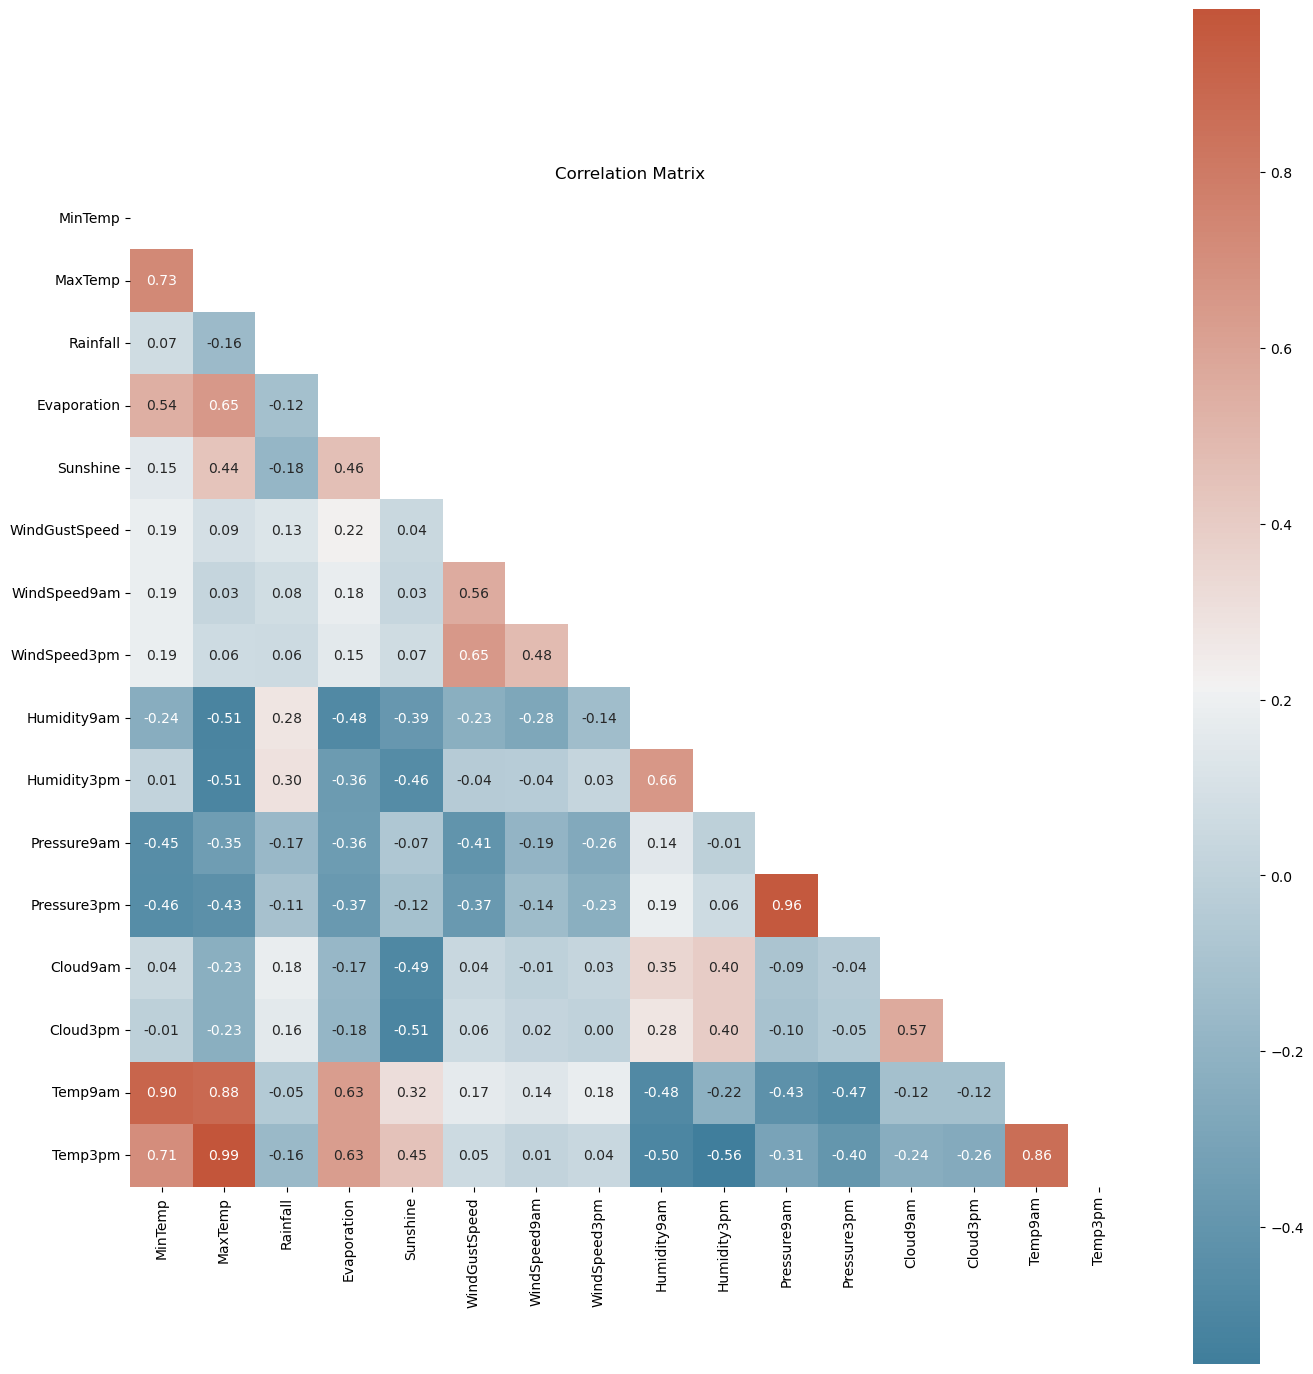

In [71]:
plt.figure(figsize=(14, 14))
plt.title('Correlation Matrix')

# Creating a mask to block the top right half of the heatmap (redundant information)
mask = np.triu(np.ones_like(df10.corr(numeric_only = True)))

# Custom color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df10.corr(numeric_only = True), mask=mask, annot=True, fmt='.2f', square=True, cmap=cmap)
plt.tight_layout()

Some Independent variables are highly correlated(corr above 0.8):
 - Temp3pm, Temp9am are highly correlated with MinTemp and MaxTemp.
 - MinTemp and MaxTemp are moderately correlated.
 - RainToday is moderately correlated with RainTomorrow.
 - Temp3pm, Temp9am are moderately correlated with Evaporation.
 - Pressure9am and Pressure3pm are highly correlated.
 
Removing highly correlated columns, as the information will be redundant and one column will be sufficient for the model learning:
 - Temp3pm
 - Temp9am
 - Pressure3pm

## Finalising DataSet

**Renaming the Rainfall Column**

In [72]:
df11.rename(columns = {'Rainfall':'Precipitation'}, inplace = True)

**Dropping Unnecessary Columns**  
The ones we OneHotEncoded and those we don't need for training.

In [73]:
df11.drop(columns = ['Date','Temp9am','Temp3pm','Month','Location','WindGustDir',
                     'WindDir9am','WindDir3pm','Pressure3pm'], inplace = True)

**Changing the Orientation of Columns**  
- Putting all Continuous(Numerical) Columns first.
- Then Discrete(Numerical) columns.
- Then OneHotEncoded Columns
- Then the Dependent variable columns.

In [74]:
#Getting the original Orientation
np.array(df11.columns)

array(['MinTemp', 'MaxTemp', 'Precipitation', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm', 'RainToday',
       'RainTomorrow', 'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar',
       'May', 'Nov', 'Oct', 'Sep', 'Albany', 'Albury', 'AliceSprings',
       'BadgerysCreek', 'Ballarat', 'Bendigo', 'Brisbane', 'Cairns',
       'Canberra', 'Cobar', 'CoffsHarbour', 'Dartmoor', 'Darwin',
       'GoldCoast', 'Hobart', 'Katherine', 'Launceston', 'Melbourne',
       'MelbourneAirport', 'Mildura', 'Moree', 'MountGambier',
       'MountGinini', 'Newcastle', 'Nhil', 'NorahHead', 'NorfolkIsland',
       'Nuriootpa', 'PearceRAAF', 'Penrith', 'Perth', 'PerthAirport',
       'Portland', 'Richmond', 'Sale', 'SalmonGums', 'Sydney',
       'SydneyAirport', 'Townsville', 'Tuggeranong', 'Uluru',
       'WaggaWagga', 'Walpole', 'Watsonia', 'Williamtown', 'Witchcliffe',
       'Wollongong', 'Woomera

In [75]:
#Editing it the way needed.
df11 =  df11[['MinTemp', 'MaxTemp', 'Precipitation', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Cloud9am', 'Cloud3pm',
       'Aug', 'Dec', 'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov',
       'Oct', 'Sep', 'Albany', 'Albury', 'AliceSprings', 'BadgerysCreek',
       'Ballarat', 'Bendigo', 'Brisbane', 'Cairns', 'Canberra', 'Cobar',
       'CoffsHarbour', 'Dartmoor', 'Darwin', 'GoldCoast', 'Hobart',
       'Katherine', 'Launceston', 'Melbourne', 'MelbourneAirport',
       'Mildura', 'Moree', 'MountGambier', 'MountGinini', 'Newcastle',
       'Nhil', 'NorahHead', 'NorfolkIsland', 'Nuriootpa', 'PearceRAAF',
       'Penrith', 'Perth', 'PerthAirport', 'Portland', 'Richmond', 'Sale',
       'SalmonGums', 'Sydney', 'SydneyAirport', 'Townsville',
       'Tuggeranong', 'Uluru', 'WaggaWagga', 'Walpole', 'Watsonia',
       'Williamtown', 'Witchcliffe', 'Wollongong', 'Woomera', 'W_ENE',
       'W_ESE', 'W_N', 'W_NE', 'W_NNE', 'W_NNW', 'W_NW', 'W_S', 'W_SE',
       'W_SSE', 'W_SSW', 'W_SW', 'W_W', 'W_WNW', 'W_WSW', 'W9_ENE',
       'W9_ESE', 'W9_N', 'W9_NE', 'W9_NNE', 'W9_NNW', 'W9_NW', 'W9_S',
       'W9_SE', 'W9_SSE', 'W9_SSW', 'W9_SW', 'W9_W', 'W9_WNW', 'W9_WSW',
       'W3_ENE', 'W3_ESE', 'W3_N', 'W3_NE', 'W3_NNE', 'W3_NNW', 'W3_NW',
       'W3_S', 'W3_SE', 'W3_SSE', 'W3_SSW', 'W3_SW', 'W3_W', 'W3_WNW',
       'W3_WSW', 'RainToday', 'RainTomorrow']]

**Finalising**
- Saving as a Final Copy
- Getting all Independent Variables in X.
- Getting Dependent Variables into arrays y1 and y2

In [76]:
Finaldf = df11.copy()
FinCol = Finaldf.columns

In [77]:
Finaldf

,MinTemp,MaxTemp,Precipitation,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW,RainToday,RainTomorrow
0,13.4,22.9,0.6,7.4,10.2,44.0,20.0,24.0,71.0,22.0,1007.7,8.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,7.4,25.1,0.0,7.4,10.2,44.0,4.0,22.0,44.0,25.0,1010.6,5.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,12.9,25.7,0.0,7.4,10.2,46.0,19.0,26.0,38.0,30.0,1007.6,5.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,9.2,28.0,0.0,7.4,10.2,24.0,11.0,9.0,45.0,16.0,1017.6,5.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,7.4,10.2,41.0,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128145,3.5,21.8,0.0,2.0,6.1,31.0,15.0,13.0,59.0,27.0,1024.7,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128146,2.8,23.4,0.0,2.0,6.1,31.0,13.0,11.0,51.0,24.0,1024.6,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128147,3.6,25.3,0.0,2.0,6.1,22.0,13.0,9.0,56.0,21.0,1023.5,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128148,5.4,26.9,0.0,2.0,6.1,37.0,9.0,9.0,53.0,24.0,1021.0,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [78]:
Finaldf.to_csv('../data/clean_data.csv')

In [79]:
X = Finaldf.drop(columns = [ 'RainToday','RainTomorrow'])
y1 = Finaldf['RainToday'].astype('int')
y2 = Finaldf['RainTomorrow'].astype('int')

In [80]:
X

,MinTemp,MaxTemp,Precipitation,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW
0,13.4,22.9,0.6,7.4,10.2,44.0,20.0,24.0,71.0,22.0,1007.7,8.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,7.4,25.1,0.0,7.4,10.2,44.0,4.0,22.0,44.0,25.0,1010.6,5.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,12.9,25.7,0.0,7.4,10.2,46.0,19.0,26.0,38.0,30.0,1007.6,5.0,2.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,9.2,28.0,0.0,7.4,10.2,24.0,11.0,9.0,45.0,16.0,1017.6,5.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,17.5,32.3,1.0,7.4,10.2,41.0,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128145,3.5,21.8,0.0,2.0,6.1,31.0,15.0,13.0,59.0,27.0,1024.7,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128146,2.8,23.4,0.0,2.0,6.1,31.0,13.0,11.0,51.0,24.0,1024.6,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
128147,3.6,25.3,0.0,2.0,6.1,22.0,13.0,9.0,56.0,21.0,1023.5,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
128148,5.4,26.9,0.0,2.0,6.1,37.0,9.0,9.0,53.0,24.0,1021.0,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [81]:
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: RainToday, dtype: int32

In [82]:
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: RainTomorrow, dtype: int32

## Splitting Dataset into Training and Test Set

In [83]:
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X,y1,y2, random_state = 1)

In [84]:
X_train.head()

,MinTemp,MaxTemp,Precipitation,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW
18290,22.6,27.0,0.0,6.0,8.5,22.0,11.0,15.0,87.0,77.0,1010.9,5.0,4.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
51954,0.6,12.0,0.4,2.2,6.6,26.0,7.0,9.0,99.0,76.0,1028.3,5.0,8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
115916,9.6,18.1,0.0,5.6,8.7,35.0,7.0,19.0,56.0,50.0,1026.3,5.0,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
111065,0.8,15.1,0.0,2.0,6.1,39.0,7.0,15.0,96.0,58.0,1021.5,5.0,5.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59481,13.7,27.1,0.0,9.0,11.4,39.0,7.0,11.0,66.0,41.0,1013.2,5.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [85]:
X_test.head()

,MinTemp,MaxTemp,Precipitation,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW
97089,10.7,16.2,2.4,1.6,6.5,37.0,6.0,19.0,79.0,90.0,1027.3,5.0,8.0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
24037,15.5,27.2,1.6,1.8,8.1,19.0,2.0,11.0,99.0,53.0,1016.6,5.0,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
78295,23.8,33.7,11.6,6.8,9.8,37.0,20.0,20.0,80.0,48.0,1010.5,4.0,5.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17317,20.4,27.5,0.0,6.8,9.8,33.0,17.0,22.0,80.0,70.0,1014.8,5.0,5.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
11099,5.5,21.3,4.0,1.6,8.7,37.0,11.0,26.0,89.0,33.0,1012.4,2.0,5.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [86]:
y1_train.head()

18290     0
51954     0
115916    0
111065    0
59481     0
Name: RainToday, dtype: int32

In [87]:
y1_test.head()

97089    1
24037    1
78295    1
17317    0
11099    1
Name: RainToday, dtype: int32

In [88]:
y2_train.head()

18290     0
51954     0
115916    0
111065    1
59481     0
Name: RainTomorrow, dtype: int32

In [89]:
y2_test.head()

97089    0
24037    0
78295    0
17317    0
11099    0
Name: RainTomorrow, dtype: int32

## Feature Scaling

Since many continuous columns have different ranges of values, it is always a good idea to feature scale them before model learning.  
There are various types of feature scaling method. Here Standard Scaling will be used since it works well for every data.


In [90]:
#To get decimal notation in describe() function
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [91]:
#Making temporary dataframes with only required columns
trainF = X_train.iloc[:,:13].copy()
testF = X_test.iloc[:,:13].copy()

In [92]:
#Object of StandardScaler Class
SS = StandardScaler()

#Applying Feature Scaling
trainF = SS.fit_transform(trainF.values)
testF = SS.transform(testF.values)

In [93]:
#Since, Standard Scalar returns an array of data, coverting it into DataFrame
trainF = pd.DataFrame(trainF, columns = FinCol[:13], index = X_train.index)
testF = pd.DataFrame(testF, columns = FinCol[:13], index = X_test.index)

In [94]:
#Putting the scaled values back into the splitted DataFrames 
X_train = pd.concat((trainF, X_train.iloc[:,13:]), axis = 1)
X_test = pd.concat((testF, X_test.iloc[:,13:]), axis = 1)

## Model Selection, Training and Comparison

The aim of the project was to predict RainToday and RainTomorrow.
1. To predict **RainToday**, I'll just use X(input variables).
2. For **RainTomorrow**, I'll go about in two ways:
    - Predicting RainTomorrow with X only.
    - Predicting RainTomorrow with X and RainToday as input variable.
    Then I'll choose that model which has high accuracy among the two.

In [95]:
#Making input variable array for case 2 of predicting RainTomorrow
X0_train = pd.concat((X_train, y1_train), axis = 1)
X0_test = pd.concat((X_test, y1_test), axis = 1)

In [96]:
#Making a function which will have various classes which are used to evaluate and compare classification models
def evaluate(model, y_train, y_test, X_train = X_train.values, X_test = X_test.values):

    #Scores
    print('Model Fitness')
    print('-'*34)
    print('Train Score :',model.score(X_train, y_train))
    print('Test Score :',model.score(X_test, y_test))

    print('\n')

    #Confusion Matrix
    print('Confusion Matrix')
    print('-'*45)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap = 'Blues')
    plt.show()

    print('\n')

    #ROC Curve
    print('ROC Curve')
    print('-'*50)
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.plot([0,1],[0,1], ls = '--')
    plt.show()

    print('\n')

    #Classification Report
    print('Classification Report')
    print('-'*53)
    print(classification_report(y_test, (model.predict(X_test))))

### Logistic Regression

**Predicting RainToday**

Model Fitness
----------------------------------
Train Score : 0.9999479773597469
Test Score : 0.9999375741307198


Confusion Matrix
---------------------------------------------


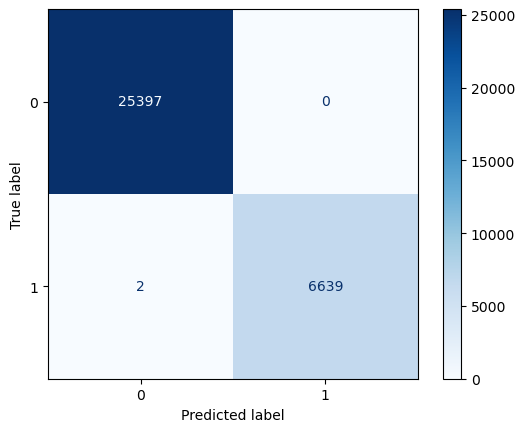



ROC Curve
--------------------------------------------------


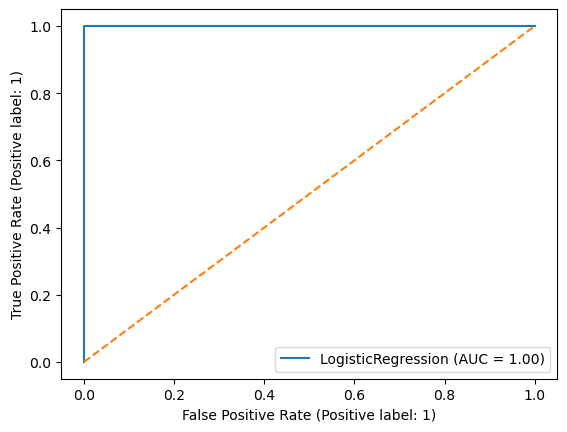



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25397
           1       1.00      1.00      1.00      6641

    accuracy                           1.00     32038
   macro avg       1.00      1.00      1.00     32038
weighted avg       1.00      1.00      1.00     32038



In [97]:
LogReg1 = LogisticRegression(max_iter = 1000, random_state = 1)

LogReg1.fit(X_train.values, y1_train.values)

evaluate(LogReg1, y_train = y1_train, y_test = y1_test)

**Predicting RainTomorrow(without using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 0.8538996171133677
Test Score : 0.8530807166489793


Confusion Matrix
---------------------------------------------


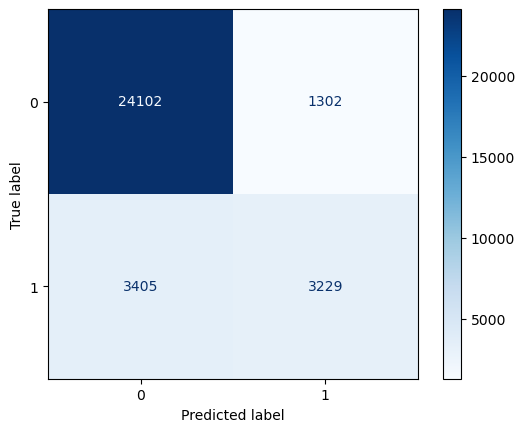



ROC Curve
--------------------------------------------------


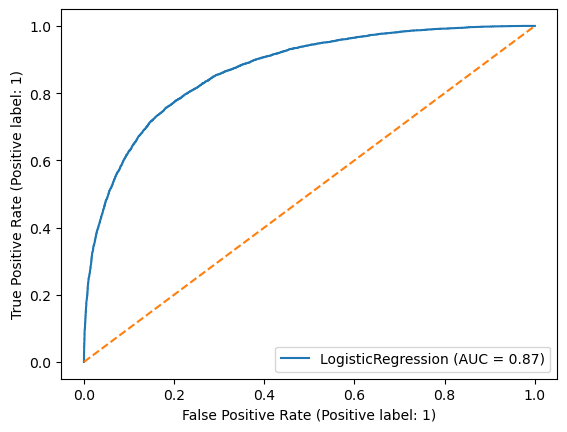



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     25404
           1       0.71      0.49      0.58      6634

    accuracy                           0.85     32038
   macro avg       0.79      0.72      0.74     32038
weighted avg       0.84      0.85      0.84     32038



In [98]:
LogReg2 = LogisticRegression(max_iter = 1000, random_state = 1)

LogReg2.fit(X_train.values, y2_train)

evaluate(LogReg2, y_train = y2_train, y_test = y2_test)

**Predicting RainTomorrow(using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 0.8541597303146329
Test Score : 0.8525500967600974


Confusion Matrix
---------------------------------------------


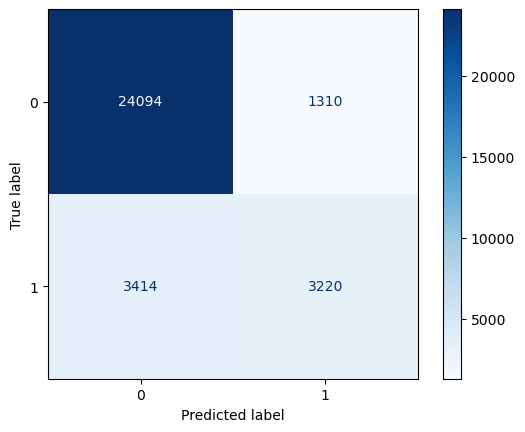



ROC Curve
--------------------------------------------------


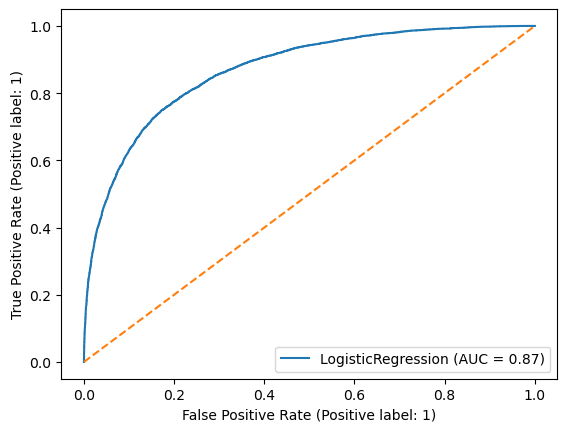



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     25404
           1       0.71      0.49      0.58      6634

    accuracy                           0.85     32038
   macro avg       0.79      0.72      0.74     32038
weighted avg       0.84      0.85      0.84     32038



In [99]:
LogReg3 = LogisticRegression(max_iter = 1000, random_state = 1)

LogReg3.fit(X0_train.values, y2_train)

evaluate(LogReg3, X_train = X0_train.values, X_test = X0_test.values, y_train = y2_train, y_test = y2_test)

   - The performance for predicting RainToday with Logistic Regression is almost 100%.
   - Predicting RainTomorrow without using RainToday as a input variable is slightly better(83.30%) than the other way around(83.25%) for Logistic Regression.
   - There is no sign of overfitting in the model as accuracies for both training and test data have very little difference.

### k Nearest Neighbors Classifier

**Predicting RainToday**

Model Fitness
----------------------------------
Train Score : 0.932328949558848
Test Score : 0.9080466945502216


Confusion Matrix
---------------------------------------------


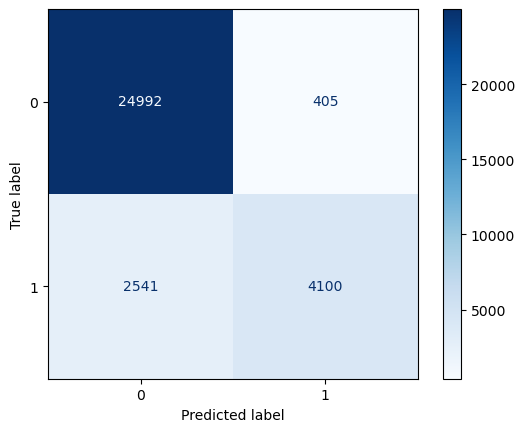



ROC Curve
--------------------------------------------------


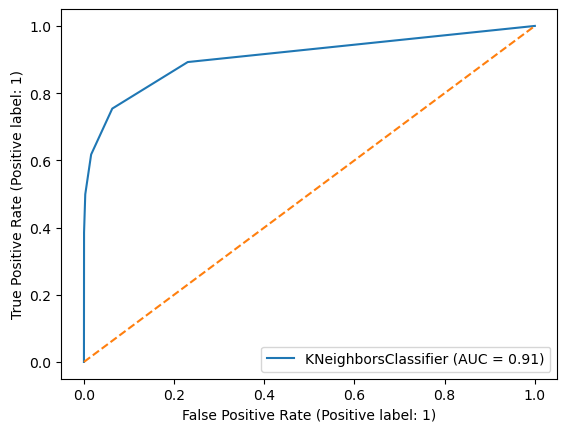



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     25397
           1       0.91      0.62      0.74      6641

    accuracy                           0.91     32038
   macro avg       0.91      0.80      0.84     32038
weighted avg       0.91      0.91      0.90     32038



In [100]:
KNN1 = KNeighborsClassifier(n_neighbors = 5)

KNN1.fit(X_train.values, y1_train)

evaluate(KNN1, y_train = y1_train, y_test = y1_test)

**Predicting RainTomorrow(without using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 0.8861328450141501
Test Score : 0.8403146263811724


Confusion Matrix
---------------------------------------------


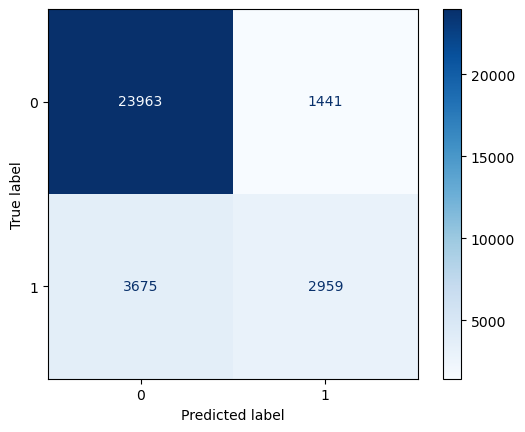



ROC Curve
--------------------------------------------------


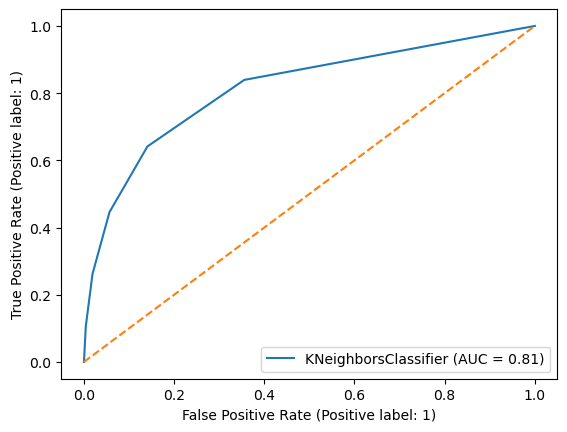



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     25404
           1       0.67      0.45      0.54      6634

    accuracy                           0.84     32038
   macro avg       0.77      0.69      0.72     32038
weighted avg       0.83      0.84      0.83     32038



In [101]:
KNN2 = KNeighborsClassifier(n_neighbors = 5)

KNN2.fit(X_train.values, y2_train)

evaluate(KNN2, y_train = y2_train, y_test = y2_test)

**Predicting RainTomorrow(using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 0.8854045280506077
Test Score : 0.8406267557275735


Confusion Matrix
---------------------------------------------


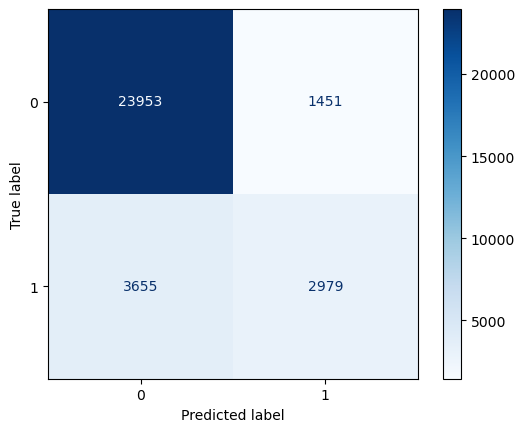



ROC Curve
--------------------------------------------------


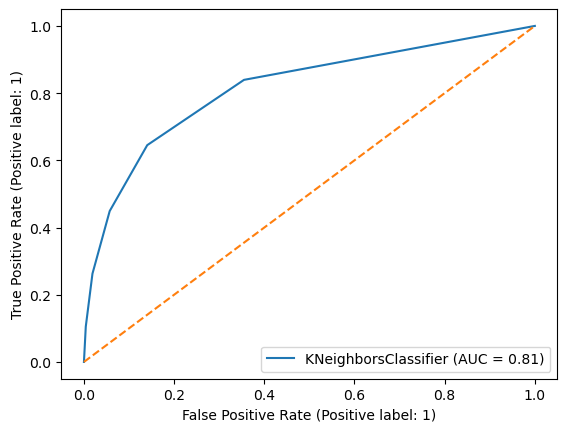



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     25404
           1       0.67      0.45      0.54      6634

    accuracy                           0.84     32038
   macro avg       0.77      0.70      0.72     32038
weighted avg       0.83      0.84      0.83     32038



In [102]:
KNN3 = KNeighborsClassifier(n_neighbors = 5)

KNN3.fit(X0_train.values, y2_train)

evaluate(KNN3, X_train = X0_train.values, X_test = X0_test.values, y_train = y2_train, y_test = y2_test)

   - The performance for predicting RainToday with KNN is 90.8%.
   - Prediction for RainTomorrow with using RainToday doesn't improve much(84.06%) as opposed to without using it(84.03%).
   - There is a little overfitting happening in all 3 models as they have better accuracies for train data as compared to test data.

### Decision Tree CLassifier

**Predicting RainToday**

Model Fitness
----------------------------------
Train Score : 1.0
Test Score : 1.0


Confusion Matrix
---------------------------------------------


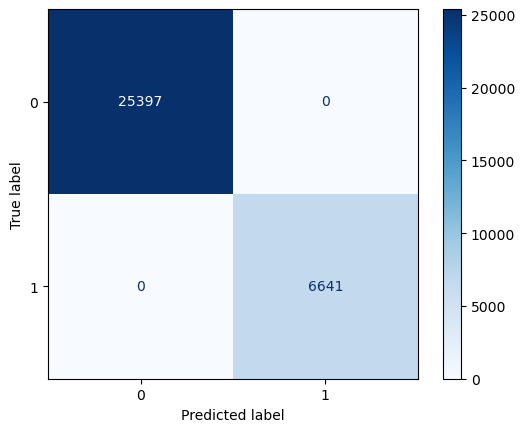



ROC Curve
--------------------------------------------------


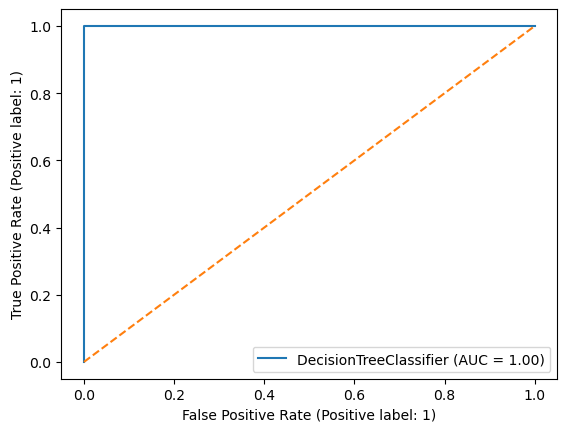



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25397
           1       1.00      1.00      1.00      6641

    accuracy                           1.00     32038
   macro avg       1.00      1.00      1.00     32038
weighted avg       1.00      1.00      1.00     32038



In [103]:
DTree1 = DecisionTreeClassifier(random_state=0)

DTree1.fit(X_train.values, y1_train)

evaluate(DTree1, y_train = y1_train, y_test = y1_test)

**Predicting RainTomorrow(without using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 1.0
Test Score : 0.7898745240027467


Confusion Matrix
---------------------------------------------


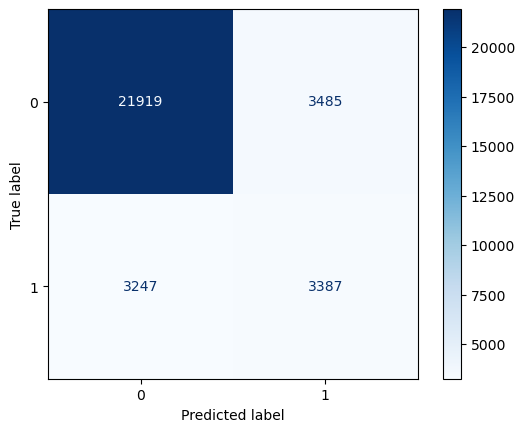



ROC Curve
--------------------------------------------------


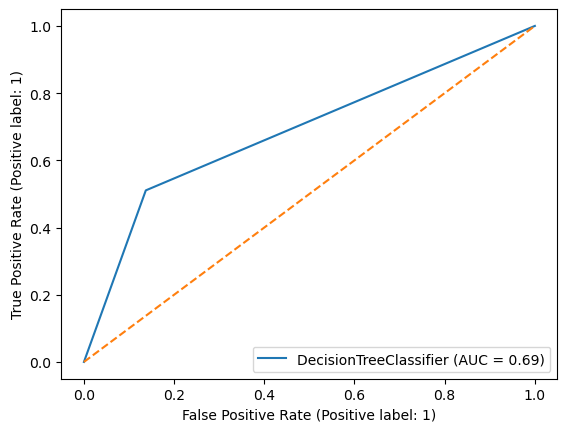



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     25404
           1       0.49      0.51      0.50      6634

    accuracy                           0.79     32038
   macro avg       0.68      0.69      0.68     32038
weighted avg       0.79      0.79      0.79     32038



In [104]:
DTree2 = DecisionTreeClassifier(random_state=0)

DTree2.fit(X_train.values, y2_train)

evaluate(DTree2, y_train = y2_train, y_test = y2_test)

**Predicting RainTomorrow(using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 1.0
Test Score : 0.7908421249765903


Confusion Matrix
---------------------------------------------


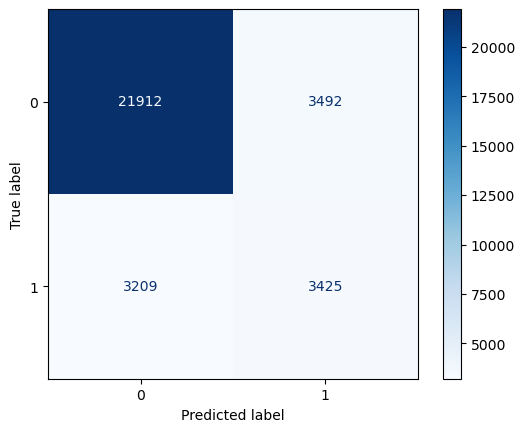



ROC Curve
--------------------------------------------------


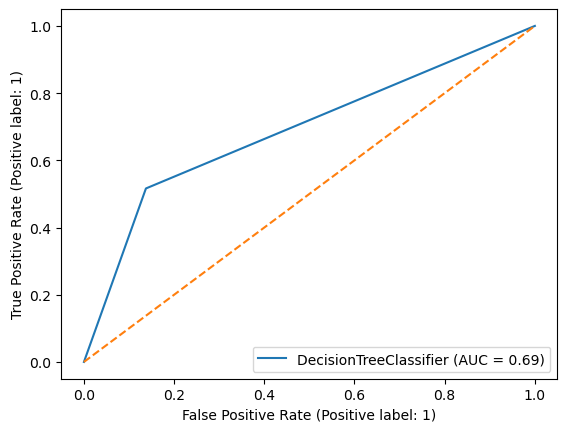



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.86      0.87     25404
           1       0.50      0.52      0.51      6634

    accuracy                           0.79     32038
   macro avg       0.68      0.69      0.69     32038
weighted avg       0.79      0.79      0.79     32038



In [105]:
DTree3 = DecisionTreeClassifier(random_state=0)

DTree3.fit(X0_train.values, y2_train)

evaluate(DTree3, X_train = X0_train.values, X_test = X0_test.values, y_train = y2_train, y_test = y2_test)

   - The performance for predicting RainToday with Decision Tree Classifier is 100%.
   - Prediction using Decision Tree has very little increase in performance when using RainToday column(79.08%) as opposed to not using it(78.98%).
   - There is a huge overfitting happening in the models predicting RainTomorrow. They have 100% accuracies for train data but for test data it is close to 80%.

### Random Forest Classifier

**Predicting RainToday**

Model Fitness
----------------------------------
Train Score : 1.0
Test Score : 1.0


Confusion Matrix
---------------------------------------------


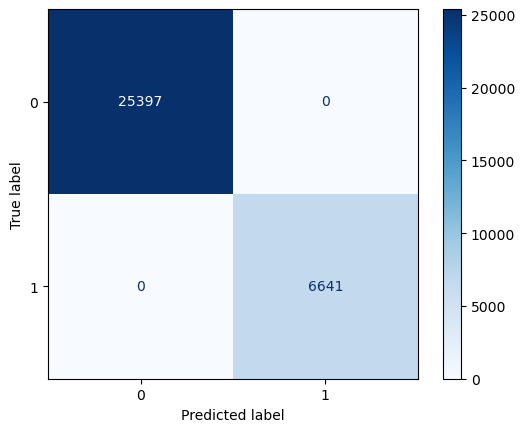



ROC Curve
--------------------------------------------------


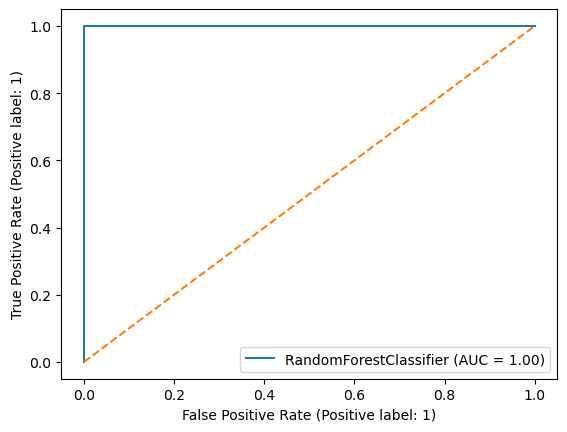



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25397
           1       1.00      1.00      1.00      6641

    accuracy                           1.00     32038
   macro avg       1.00      1.00      1.00     32038
weighted avg       1.00      1.00      1.00     32038



In [106]:
RandFor1 = RandomForestClassifier()

RandFor1.fit(X_train.values, y1_train)

evaluate(RandFor1, y_train = y1_train, y_test = y1_test)

**Predicting RainTomorrow(without using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 0.9999791909438988
Test Score : 0.8596666458580435


Confusion Matrix
---------------------------------------------


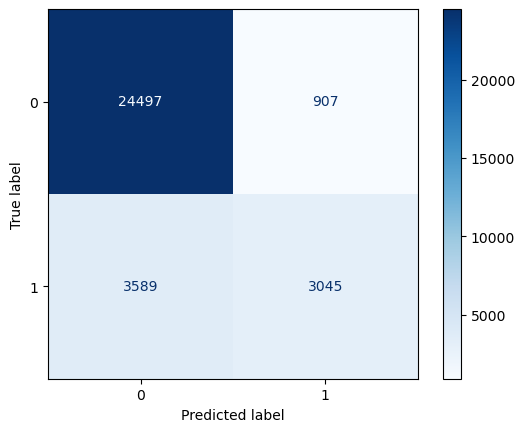



ROC Curve
--------------------------------------------------


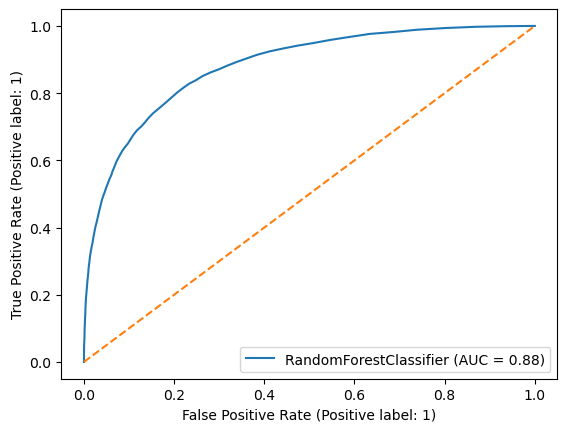



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.96      0.92     25404
           1       0.77      0.46      0.58      6634

    accuracy                           0.86     32038
   macro avg       0.82      0.71      0.75     32038
weighted avg       0.85      0.86      0.85     32038



In [107]:
RandFor2 = RandomForestClassifier()

RandFor2.fit(X_train.values, y2_train)

evaluate(RandFor2, y_train = y2_train, y_test = y2_test)

**Predicting RainTomorrow(using RainToday as a learning variable)**

Model Fitness
----------------------------------
Train Score : 0.9999687864158482
Test Score : 0.8581996379299581


Confusion Matrix
---------------------------------------------


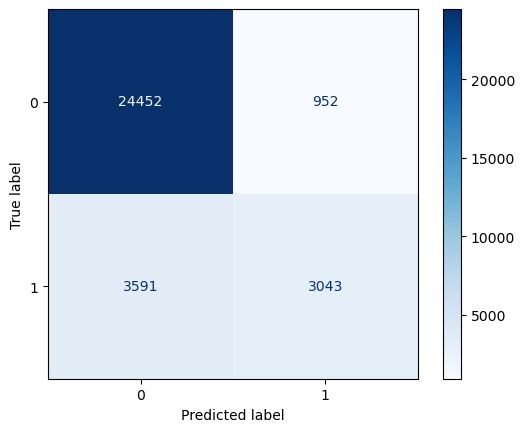



ROC Curve
--------------------------------------------------


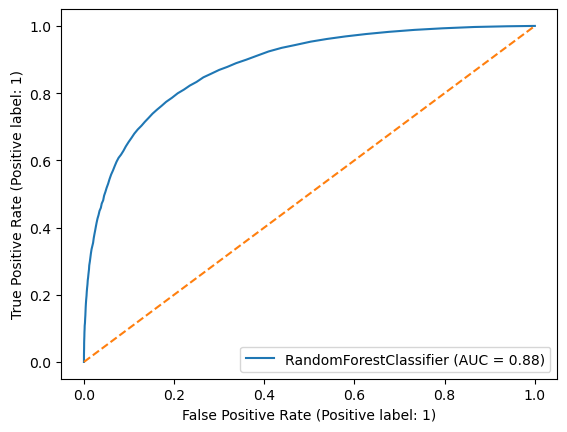



Classification Report
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     25404
           1       0.76      0.46      0.57      6634

    accuracy                           0.86     32038
   macro avg       0.82      0.71      0.74     32038
weighted avg       0.85      0.86      0.84     32038



In [108]:
RandFor3 = RandomForestClassifier()

RandFor3.fit(X0_train.values, y2_train)

evaluate(RandFor3, X_train = X0_train.values, X_test = X0_test.values, y_train = y2_train, y_test = y2_test)

   - The performance for predicting RainToday with Random Forest Classifier is 100%.
   - Prediction for RainTomorrow using this algorithm has very very small improvement in performance when using RainToday column(85.99%) as opposed to not using it(85.95%).
   - There is a huge overfitting happening in the models predicting RainTomorrow. They have 100% accuracies for train data but for test data it is close to 85%%.

### CONCLUSION
For predicting **RainTomorrow**, using RainToday column doesn't matter much because the increase in accuracies is not significant. So we'll go for models without using RainToday column.

**RainToday**

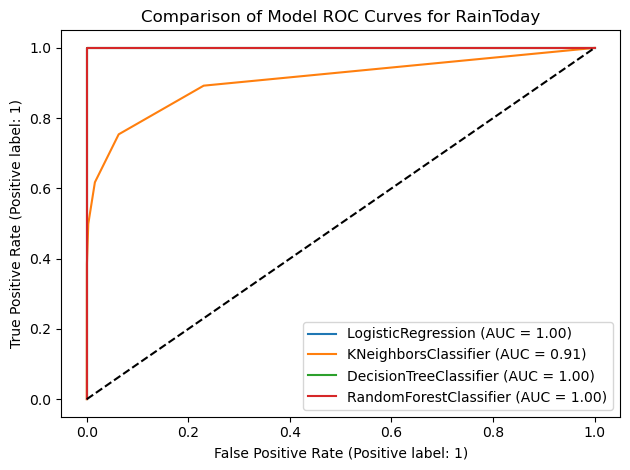

In [109]:
models = [LogReg1, KNN1, DTree1, RandFor1]
fig, ax = plt.subplots()
for model in models:
    RocCurveDisplay.from_estimator(model, X_test.values, y1_test, ax=ax)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Comparison of Model ROC Curves for RainToday')
plt.tight_layout()

**RainTomorrow**

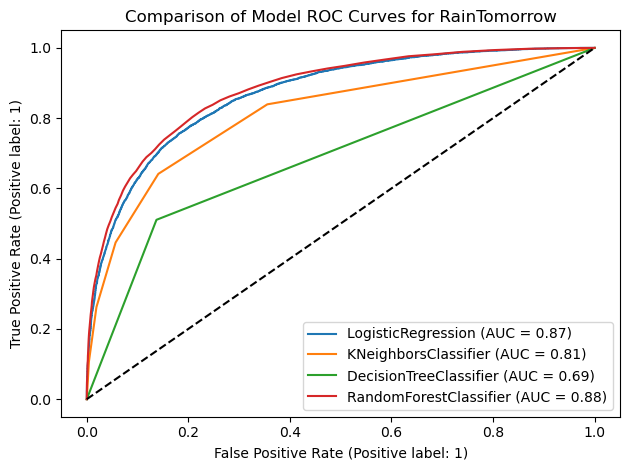

In [110]:
models = [LogReg2, KNN2, DTree2, RandFor2]
fig, ax = plt.subplots()
for model in models:
    RocCurveDisplay.from_estimator(model, X_test.values, y2_test, ax=ax)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('Comparison of Model ROC Curves for RainTomorrow')
plt.tight_layout()

- For predicting **RainToday**, all models except KNN have 100% accuracies. We'll use Decision Tree for this purpose(DTree1)
- For predicting **RainTomorrow**, best model to use is Random Forrest Classifier(RandFor2) but it overfits a lot as it fits perfectly over the train data but not on test data. Therefore, we'll use next best model, i.e., Logistic Regression as it doesn't overfit and works best for both training and test data.

## Prediction

Code of lines to input custom values for prediction.

In [111]:
#Input Values
mT = 19.0
MT = 27.0
ppt = 1.0
Evap = 5.0
Sun = 9.5
WSp = 69.0
WS9 = 18.0
WS3 = 32.5
Hm9 = 52
Hm3 = 54
P9 = 1000
Cld9 = 3.0
Cld3 = 2.0
Month = 'Apr'
Loc = 'Albury'
WD = 'E'
WD9 = 'SSE'
WD3 = 'NNW'


#Initialise a empty array
A = np.array(X_train.columns)
NewEg = np.zeros(A.shape)

#Fill array with custom values that were input
NewEg[0] = mT
NewEg[1] = MT
NewEg[2] = ppt
NewEg[3] = Evap
NewEg[4] = Sun
NewEg[5] = WSp
NewEg[6] = WS9
NewEg[7] = WS3
NewEg[8] = Hm9
NewEg[9] = Hm3
NewEg[10] = P9
NewEg[11] = Cld9
NewEg[12] = Cld3

if(Month != 'Apr'):
    i = np.where(A == Month)[0][0]
    NewEg[i] = 1

if(Loc != 'Adelaide'):
    j = np.where(A == Loc)[0][0]
    NewEg[j] = 1

WD = 'W_'+ WD
if(WD != 'W_E'):
    k = np.where(A == WD)[0][0]
    NewEg[k] = 1

WD9 = 'W9_' + WD9
if(WD9 != 'W9_E'):
    l = np.where(A == WD9)[0][0]
    NewEg[l] = 1

WD3 = 'W3_' + WD3
if(WD3 != 'W3_E'):
    m = np.where(A == WD3)[0][0]
    NewEg[m] = 1

    
#Check if correct
pd.DataFrame(data = [NewEg], columns = A)

,MinTemp,MaxTemp,Precipitation,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Albany,Albury,AliceSprings,BadgerysCreek,Ballarat,Bendigo,Brisbane,Cairns,Canberra,Cobar,CoffsHarbour,Dartmoor,Darwin,GoldCoast,Hobart,Katherine,Launceston,Melbourne,MelbourneAirport,Mildura,Moree,MountGambier,MountGinini,Newcastle,Nhil,NorahHead,NorfolkIsland,Nuriootpa,PearceRAAF,Penrith,Perth,PerthAirport,Portland,Richmond,Sale,SalmonGums,Sydney,SydneyAirport,Townsville,Tuggeranong,Uluru,WaggaWagga,Walpole,Watsonia,Williamtown,Witchcliffe,Wollongong,Woomera,W_ENE,W_ESE,W_N,W_NE,W_NNE,W_NNW,W_NW,W_S,W_SE,W_SSE,W_SSW,W_SW,W_W,W_WNW,W_WSW,W9_ENE,W9_ESE,W9_N,W9_NE,W9_NNE,W9_NNW,W9_NW,W9_S,W9_SE,W9_SSE,W9_SSW,W9_SW,W9_W,W9_WNW,W9_WSW,W3_ENE,W3_ESE,W3_N,W3_NE,W3_NNE,W3_NNW,W3_NW,W3_S,W3_SE,W3_SSE,W3_SSW,W3_SW,W3_W,W3_WNW,W3_WSW
0,19.00000,27.00000,1.00000,5.00000,9.50000,69.00000,18.00000,32.50000,52.00000,54.00000,1000.00000,3.00000,2.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [112]:
#Scale it accordingly
[NewEg[:13]] = SS.transform([NewEg[:13]])


#Forecast
print('Forecast')
print('-'*9)

#Prediction Variables
Res1 = DTree1.predict([NewEg])[0]
ResP1 = round(DTree1.predict_proba([NewEg])[0][1], 4) * 100
if(Res1 == 1):
    Res = 'Yes'
else:
    Res = 'No'

Res2 = LogReg2.predict([NewEg])[0]
ResP2 = round(LogReg2.predict_proba([NewEg])[0][1], 4) * 100
if(Res == 1):
    Res = 'Yes'
else:
    Res = 'No'
    
#Result    
print('Will it Rain Today? {ans}'.format(ans = Res1))
print('Chances of Raining: {perc}%'.format(perc = ResP1))
print("\n")
print('Will it Rain Tomorrow? {ans}'.format(ans = Res2))
print('Chances of Raining Tomorrow: {perc}%'.format(perc = ResP2))

Forecast
---------
Will it Rain Today? 0
Chances of Raining: 0.0%


Will it Rain Tomorrow? 1
Chances of Raining Tomorrow: 76.64%


## Deployment

In [113]:
with open("../models/Rain_Prediction.pickle", 'wb') as f:
    pickle.dump(SS, f)
    pickle.dump(DTree1,f)
    pickle.dump(LogReg2, f)

In [114]:
columns = {'Data Columns': [i.lower() for i in A]}

with open('../data/Columns.json','w') as f:
    f.write(json.dumps(columns))